In [1]:
# --- Cell 1: Environment Setup and Start MLflow Run ---
from dotenv import load_dotenv
import os
import mlflow

# Load environment variables from .env file
load_dotenv()

# Get credentials and URI from environment variables
MLFLOW_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

# These lines are crucial for MLflow to authenticate with your server
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_PASSWORD

# Set the tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Define an experiment name
# If the experiment doesn't exist, MLflow creates it.
EXPERIMENT_NAME = "UCI Adult Income Prediction - Centralized"
mlflow.set_experiment(EXPERIMENT_NAME)

# Start a new run manually. We'll end it later.
# It's good practice to give your run a descriptive name.
current_run = mlflow.start_run(run_name="Initial_Setup_and_Connection_Test")
print(f"MLflow Run Name: {current_run.data.tags.get('mlflow.runName')}")
print(f"MLflow Run ID: {current_run.info.run_id}")
print(f"MLflow Experiment ID: {current_run.info.experiment_id}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow artifact URI: {mlflow.get_artifact_uri()}")

# You can log a simple parameter to test
mlflow.log_param("connection_status", "successful")

MLflow Run Name: Initial_Setup_and_Connection_Test
MLflow Run ID: 2f1e8097bb144e1b8488a6ce6e4ccee2
MLflow Experiment ID: 2
MLflow tracking URI: http://135.235.251.124
MLflow artifact URI: wasbs://artifactroot@tharindumlflow0aa3981a.blob.core.windows.net/2/2f1e8097bb144e1b8488a6ce6e4ccee2/artifacts


'successful'

In [2]:
# --- Cell X: End the MLflow Run ---
if mlflow.active_run(): # Check if a run is active before trying to end it
    mlflow.end_run()
    print("MLflow run ended.")
else:
    print("No active MLflow run to end.")

🏃 View run Initial_Setup_and_Connection_Test at: http://135.235.251.124/#/experiments/2/runs/2f1e8097bb144e1b8488a6ce6e4ccee2
🧪 View experiment at: http://135.235.251.124/#/experiments/2
MLflow run ended.


In [3]:
# --- Notebook Cell: Data Ingestion and Initial Preparation ---
# Make sure you've run the initial MLflow setup cell first to set the tracking URI and experiment.

import pandas as pd
import json # For handling JSON data
from ucimlrepo import fetch_ucirepo # To get the dataset

# --- Start a new MLflow run for this data loading & prep phase ---
# (This assumes your MLFLOW_TRACKING_URI, USERNAME, PASSWORD are set via os.environ
# and mlflow.set_experiment() has been called from the previous setup cell)

# If a run is already active from a previous cell, you might want to end it first
if mlflow.active_run():
    mlflow.end_run()
    print("Ended previous active run.")

# Start a new run for data ingestion
data_ingestion_run = mlflow.start_run(run_name="Data_Ingestion_and_Initial_Prep")
print(f"Starting new MLflow Run for Data Ingestion: {data_ingestion_run.data.tags.get('mlflow.runName')}")
print(f"Run ID: {data_ingestion_run.info.run_id}")

# --- 1. Fetch Dataset ---
print("Fetching UCI Adult dataset...")
try:
    adult_dataset_info = fetch_ucirepo(id=2) # id=2 is for the Adult dataset
    X_raw = adult_dataset_info.data.features
    y_raw = adult_dataset_info.data.targets
    print("Dataset fetched successfully.")
except Exception as e:
    print(f"Error fetching dataset: {e}")
    mlflow.log_param("data_fetching_status", "failed")
    mlflow.log_param("data_fetching_error", str(e))
    if mlflow.active_run(): mlflow.end_run() # End run if fetching fails
    raise # Re-raise the exception to stop execution

# --- 2. Combine Features and Target ---
# For easier handling, let's put features and target into one DataFrame
df_raw = pd.concat([X_raw, y_raw], axis=1)
print("\nCombined DataFrame head (first 5 rows):")
print(df_raw.head())

# --- 3. Basic Data Type Conversion ---
# Some integer columns might be better as floats for later processing
# or to handle potential NaNs more consistently.
int_columns = df_raw.select_dtypes(include='int64').columns
if not int_columns.empty:
    df_raw[int_columns] = df_raw[int_columns].astype('float64')
    print(f"\nConverted integer columns to float: {list(int_columns)}")
    mlflow.log_param("int_columns_converted_to_float", list(int_columns))
else:
    print("\nNo int64 columns found to convert.")
    mlflow.log_param("int_columns_converted_to_float", "None")

target_column_name = y_raw.columns[0] # Get the target column name (e.g., 'income')

# --- 4. Logging Dataset as an MLflow Input ---
# MLflow can track datasets as inputs, which helps with lineage.
print(f"\nLogging dataset as MLflow input. Target column: '{target_column_name}'")
try:
    mlflow_dataset = mlflow.data.from_pandas(
        df_raw,
        source=adult_dataset_info.metadata.get('data_url', 'UCI Repository ID 2'),
        name="UCI Adult Income - Raw Combined",
        targets=target_column_name
    )
    mlflow.log_input(mlflow_dataset, context="raw_dataset") # context is a tag
    print("Dataset logged as MLflow input.")
    mlflow.log_param("raw_dataset_logged_as_input", "success")
except Exception as e:
    print(f"Error logging dataset as MLflow input: {e}")
    mlflow.log_param("raw_dataset_logged_as_input", "failed")
    mlflow.log_param("raw_dataset_logging_error", str(e))


# --- 5. Save and Log Dataset Metadata as Artifacts ---
# The fetched dataset has metadata. Let's save this as a JSON artifact.
# This is handy for understanding where the data came from, variable descriptions, etc.

# Create a local directory to temporarily store artifacts before logging
# This is good practice if you have multiple files or want to organize them.
local_artifacts_dir = "temp_data_ingestion_artifacts"
os.makedirs(local_artifacts_dir, exist_ok=True)

# Save original UCI metadata
uci_metadata_file_path = os.path.join(local_artifacts_dir, "uci_adult_dataset_metadata.json")
try:
    with open(uci_metadata_file_path, "w") as f:
        json.dump(adult_dataset_info.metadata, f, indent=4)
    mlflow.log_artifact(uci_metadata_file_path, artifact_path="dataset_description")
    print(f"\nUCI dataset metadata logged to MLflow artifacts: {uci_metadata_file_path}")
except Exception as e:
    print(f"Error logging UCI metadata: {e}")

# Save variable information from UCI
uci_variables_file_path = os.path.join(local_artifacts_dir, "uci_adult_dataset_variables.json")
try:
    # Convert DataFrame to dict for JSON serialization if it's a DataFrame
    variables_info_serializable = adult_dataset_info.variables.to_dict(orient='records') if isinstance(adult_dataset_info.variables, pd.DataFrame) else adult_dataset_info.variables
    with open(uci_variables_file_path, "w") as f:
        json.dump(variables_info_serializable, f, indent=4)
    mlflow.log_artifact(uci_variables_file_path, artifact_path="dataset_description")
    print(f"UCI dataset variable info logged to MLflow artifacts: {uci_variables_file_path}")
except Exception as e:
    print(f"Error logging UCI variable info: {e}")


# --- 6. Extract and Log Unique Values for Categorical Features ---
# Knowing unique values in categorical columns is key for EDA and preprocessing.
unique_values_categorical = {}
# Select columns that are 'object' (strings) or 'category' type
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()

# Make sure the target column isn't accidentally included if it's an object type
if target_column_name in categorical_cols:
    categorical_cols.remove(target_column_name)
    
for col in categorical_cols:
    # df_raw[col].dropna().unique() ensures we don't include NaN if it's treated as a category
    unique_values_categorical[col] = [str(val) for val in df_raw[col].dropna().unique().tolist()]


unique_values_file_path = os.path.join(local_artifacts_dir, "categorical_features_unique_values.json")
try:
    with open(unique_values_file_path, "w") as f:
        json.dump(unique_values_categorical, f, indent=4)
    mlflow.log_artifact(unique_values_file_path, artifact_path="dataset_description")
    print(f"Unique values for categorical features logged to MLflow artifacts: {unique_values_file_path}")
except Exception as e:
    print(f"Error logging unique categorical values: {e}")

# --- 7. Log Dataset Overview Parameters ---
# Let's log some general stats about the dataset as MLflow parameters.
# This gives a quick overview in the MLflow UI for this run.
print("\nLogging dataset overview parameters to MLflow...")
try:
    dataset_params = {
        "dataset_name": "UCI Adult Income",
        "source_repository_id": adult_dataset_info.metadata.get('uci_id', 2),
        "num_rows_raw": df_raw.shape[0],
        "num_columns_raw_total": df_raw.shape[1],
        "num_features_raw": X_raw.shape[1],
        "num_target_columns_raw": y_raw.shape[1],
        "column_names_raw": df_raw.columns.tolist(),
        "numerical_columns_count_raw": df_raw.select_dtypes(include='number').shape[1],
        "categorical_columns_count_raw": len(categorical_cols),
        "categorical_column_names_raw": categorical_cols,
        "numerical_column_names_raw": df_raw.select_dtypes(include='number').columns.tolist(),
        "missing_values_total_raw": int(df_raw.isnull().sum().sum()),
        "target_column_name": target_column_name,
        "target_unique_values_count": df_raw[target_column_name].nunique(),
        "target_unique_values_list": [str(val) for val in df_raw[target_column_name].unique().tolist()],
        "target_value_counts": {str(k): v for k, v in df_raw[target_column_name].value_counts().to_dict().items()},
        "target_value_counts_percentage": {str(k): v for k, v in df_raw[target_column_name].value_counts(normalize=True).to_dict().items()}
    }
    # MLflow parameters have a length limit (often 250 chars for value), so for long lists, consider logging as a text artifact.
    # For this example, we'll try logging directly.
    for key, value in dataset_params.items():
        if isinstance(value, (list, dict)):
            # Convert lists/dicts to string for parameters, or log them as JSON artifacts if too long/complex
            try:
                mlflow.log_param(key, json.dumps(value))
            except TypeError: # handles cases where json.dumps might fail for complex objects
                 mlflow.log_param(key, str(value))

        else:
            mlflow.log_param(key, value)
    print("Dataset overview parameters logged.")
except Exception as e:
    print(f"Error logging dataset parameters: {e}")


# --- 8. Log a Sample of the Raw Data as an Artifact (e.g., CSV) ---
# This can be useful for quick inspection from the MLflow UI.
# Be mindful of data size; log a small sample if the dataset is large.
sample_df_path = os.path.join(local_artifacts_dir, "raw_data_sample.csv")
try:
    df_raw.head(100).to_csv(sample_df_path, index=False) # Log first 100 rows
    mlflow.log_artifact(sample_df_path, artifact_path="dataset_samples")
    print(f"Logged a sample of raw data to MLflow artifacts: {sample_df_path}")
except Exception as e:
    print(f"Error logging data sample: {e}")

# Clean up temporary local artifacts directory (optional)
# import shutil
# shutil.rmtree(local_artifacts_dir)
# print(f"Removed temporary local artifacts directory: {local_artifacts_dir}")

print(f"\nData ingestion and initial preparation run finished. Check MLflow UI for run ID: {data_ingestion_run.info.run_id}")

# --- End the current MLflow run ---
if mlflow.active_run():
    mlflow.end_run()
    print("MLflow run for Data Ingestion ended.")

Starting new MLflow Run for Data Ingestion: Data_Ingestion_and_Initial_Prep
Run ID: 722acd6f6a4e44c78410ceb908289797
Fetching UCI Adult dataset...
Dataset fetched successfully.

Combined DataFrame head (first 5 rows):
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialt

/Users/tharindu/git/mlflow_iris_example/.venv/lib/python3.10/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'https://archive.ics.uci.edu/static/public/2/data.csv'. Exception: 
  return _dataset_source_registry.resolve(


Dataset logged as MLflow input.

UCI dataset metadata logged to MLflow artifacts: temp_data_ingestion_artifacts/uci_adult_dataset_metadata.json
UCI dataset variable info logged to MLflow artifacts: temp_data_ingestion_artifacts/uci_adult_dataset_variables.json
Unique values for categorical features logged to MLflow artifacts: temp_data_ingestion_artifacts/categorical_features_unique_values.json

Logging dataset overview parameters to MLflow...
Dataset overview parameters logged.
Logged a sample of raw data to MLflow artifacts: temp_data_ingestion_artifacts/raw_data_sample.csv

Data ingestion and initial preparation run finished. Check MLflow UI for run ID: 722acd6f6a4e44c78410ceb908289797
🏃 View run Data_Ingestion_and_Initial_Prep at: http://135.235.251.124/#/experiments/2/runs/722acd6f6a4e44c78410ceb908289797
🧪 View experiment at: http://135.235.251.124/#/experiments/2
MLflow run for Data Ingestion ended.


### Ensuring Seamless Artifact Uploads: Azure Permissions

A common hurdle when logging artifacts to a cloud-based MLflow server, especially one using Azure Blob Storage, is ensuring your Python client has the right permissions. You might see errors like `AuthorizationPermissionMismatch` in your logs when your script tries to `mlflow.log_artifact()`. This happens because the MLflow client uploads artifacts *directly* to the configured blob storage, not by proxying through the MLflow server.

Here's how to ensure your setup has the correct permissions:

#### 1. For Local Development (Your Computer)

When running MLflow scripts from your local machine, the client typically uses your Azure CLI (`az login`) credentials. To grant the necessary permissions:

*   **Required Role:** Your Azure user account needs the **"Storage Blob Data Contributor"** role on the Azure Storage Account you configured for MLflow artifacts.
*   **Assigning the Role:**
    *   **Azure Portal:** Navigate to your Storage Account -> Access control (IAM) -> Add role assignment. Search for "Storage Blob Data Contributor", select your user, and assign.
    *   **Azure CLI:**
      ```bash
      # Ensure your RESOURCE_GROUP and STORAGE_ACCOUNT_NAME variables are set
      AZURE_USER_PRINCIPAL_NAME=$(az account show --query user.name -o tsv)
      az role assignment create \
          --assignee "$AZURE_USER_PRINCIPAL_NAME" \
          --role "Storage Blob Data Contributor" \
          --scope "/subscriptions/$(az account show --query id -o tsv)/resourceGroups/$RESOURCE_GROUP/providers/Microsoft.Storage/storageAccounts/$STORAGE_ACCOUNT_NAME"
      ```
*   **Refresh Credentials:** After assigning the role (it might take a few minutes to propagate), log out and back in with Azure CLI:
    ```bash
    az logout
    az login --use-device-code
    ```
    Also, ensure the `azure-identity` Python package is installed in your environment (`pip install azure-identity`).

#### 2. For Remote Jupyter Environments in Azure (e.g., Azure VMs, AML Compute Instances)

For code running on Azure resources, **User-Assigned Managed Identities (UAMIs)** are the best practice for secure, credential-less authentication to Azure services.

*   **Concept:** You create a UAMI, grant it the "Storage Blob Data Contributor" role on your storage account, and then assign this UAMI to your Azure compute resource (like a VM or AML Compute Instance). Your Python code, using `azure-identity`, will automatically use this managed identity.

*   **Steps:**
    1.  **Create UAMI & Grant Permissions:**
        ```bash
        # Set your RESOURCE_GROUP and STORAGE_ACCOUNT_NAME if not already set
        UAMI_NAME="mlflow-artifact-writer-uami"
        az identity create --resource-group $RESOURCE_GROUP --name $UAMI_NAME
        UAMI_PRINCIPAL_ID=$(az identity show --resource-group $RESOURCE_GROUP --name $UAMI_NAME --query principalId -o tsv)

        az role assignment create \
            --assignee "$UAMI_PRINCIPAL_ID" \
            --role "Storage Blob Data Contributor" \
            --scope "/subscriptions/$(az account show --query id -o tsv)/resourceGroups/$RESOURCE_GROUP/providers/Microsoft.Storage/storageAccounts/$STORAGE_ACCOUNT_NAME"
        ```
    2.  **Assign UAMI to Compute Resource:**
        *   **Azure VM:** `az vm identity assign --resource-group <rg> --name <vm-name> --identities <uami-resource-id>`
        *   **Azure ML Compute Instance:** Assign the UAMI during creation or through its settings in the Azure ML Studio.
    3.  **Python Code:** No changes are usually needed in your MLflow Python code if `azure-identity` is installed. `DefaultAzureCredential` will pick up the managed identity. Your `.env` file (or environment variables) will still need the `MLFLOW_TRACKING_URI`, `MLFLOW_TRACKING_USERNAME`, and `MLFLOW_TRACKING_PASSWORD` for authenticating with the MLflow server itself.

By correctly configuring these permissions, your MLflow client will be able to log artifacts seamlessly to your centralized Azure Blob Storage.

# MLflow setup

In [2]:
import os
import mlflow

MLFLOW_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult")
mlflow.start_run(run_name="EDA")

2025/05/11 20:45:23 INFO mlflow.tracking.fluent: Experiment with name 'Adult' does not exist. Creating a new experiment.


<ActiveRun: >

# Data Loading

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

# Data Combination

In [4]:
import pandas as pd

# Combine features and target into one DataFrame
df = pd.concat([X, y], axis=1)
print("Data sample after combining X and y:")
df


Data sample after combining X and y:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [5]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [6]:
int_columns = df.select_dtypes(include='int64').columns
df[int_columns] = df[int_columns].astype('float64')


In [7]:
df.dtypes

age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
income             object
dtype: object

In [8]:
target_column = y.columns[0]

# Create a Dataset object from the DataFrame
dataset = mlflow.data.from_pandas(df, name="UCI Adult Income", targets=target_column)

mlflow.log_input(dataset, context="dataset")

In [6]:
import json

# Define the directory name
metadata_dir = "../data/metadata"

# Create the directory if it doesn't exist
os.makedirs(metadata_dir, exist_ok=True)

metadata_file_path = os.path.join(metadata_dir, "adult_metadata.json")
with open(metadata_file_path, "w") as f:
    json.dump(adult.metadata, f, indent=2)


unique_values = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_values[col] = df[col].dropna().unique().tolist()


unique_values_file_path = os.path.join(metadata_dir, "unique_values.json")
with open(unique_values_file_path, "w") as f:
    json.dump(unique_values, f, indent=2)


In [7]:
mlflow.log_artifact(unique_values_file_path, artifact_path="metadata")
mlflow.log_artifact(metadata_file_path, artifact_path="metadata")

# Initial Data Inspection

In [8]:
# Check the dimensions and basic info
print("Dataset shape:", df.shape)
df.info()
print(df.describe())

# For categorical columns, you can view unique values as well
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"Unique values for {col}: {df[col].unique()}")


Dataset shape: (48842, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
                age        fnlwgt  education-num  capital-gain  ca

### 🔍 Problem:
```
['<=50K', '>50K', '<=50K.', '>50K.']
```

This means the **same labels** appear with and without a **trailing period (`.`)**.

---

### 📌 Cause:
The UCI Adult dataset comes in two files:
- **`adult.data`** (no headers, training data)
- **`adult.test`** (starts with a header/comment line, test data)

In the `adult.test` file, **labels have a period** at the end — i.e., `'>50K.'` and '`<=50K.'`.

---

### ⚠️ Why It Matters:
- Your model might treat `'<=50K'` and '`<=50K.'` as **different classes**, which leads to:
  - Incorrect label counts
  - Misleading model evaluation
  - Skewed visualizations

---

### ✅ Solution:
Standardize the labels early during preprocessing:

In [9]:
# Strip whitespace and trailing periods from income
df['income'] = df['income'].str.strip().str.replace('.', '', regex=False)


# Handling Missing Values

In [10]:
import numpy as np

# Replace '?' with np.nan for consistent missing value notation
df.replace('?', np.nan, inplace=True)

# Check the number of missing values per column
print("Missing values count:")
print(df.isnull().sum())

# Calculate percentage of missing values (optional)
missing_percent = df.isnull().mean() * 100
print("Missing values percentage per column:")
print(missing_percent)


Missing values count:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64
Missing values percentage per column:
age               0.000000
workclass         5.730724
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.751198
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.754637
income            0.000000
dtype: float64


In [11]:
for col in categorical_cols:
    df[col].fillna('Unknown', inplace=True)

/tmp/ipykernel_761216/2383048195.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


## Display and log dataset metadata

In [12]:
# Log basic info
mlflow.log_params({
    "dataset_name": "adult",
    "no_of_cols": df.shape[1],
    "no_of_rows": df.shape[0],
    "columns": ','.join(df.columns.tolist()),
    "numerical_columns_count": df.select_dtypes(include='number').shape[1],
    "missing_values_total": int(df.isnull().sum().sum()),
    "target_column": "income",
    "categorical_columns_count": len(categorical_cols),
    "categorical_columns": ','.join(categorical_cols),
    "numerical_columns": ','.join(df.select_dtypes(include='number').columns.tolist()),
    "target_column_unique_values": df['income'].nunique(),
    "target_column_unique_values_list": ','.join(df['income'].unique().tolist()),
    "target_column_value_counts": df['income'].value_counts().to_dict(),
    "target_column_value_counts_percentage": df['income'].value_counts(normalize=True).to_dict()
})


# Exploratory Data Analysis (EDA)
## EDA for Numerical Features

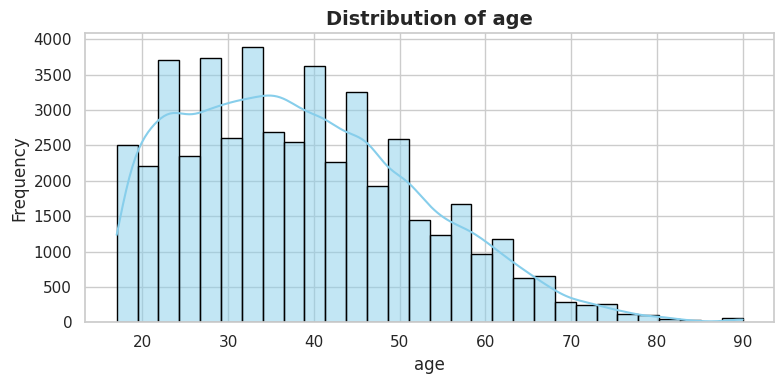

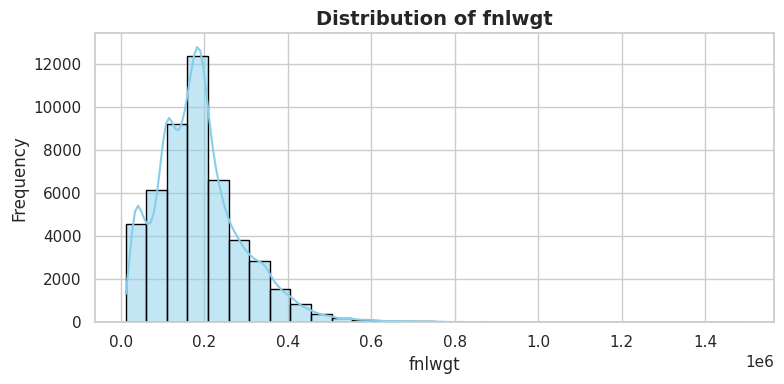

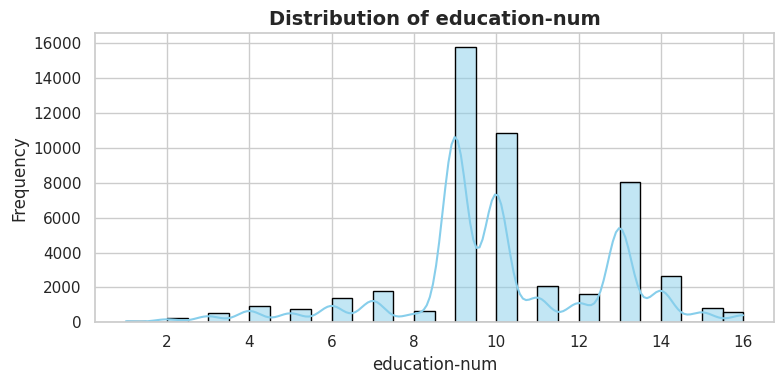

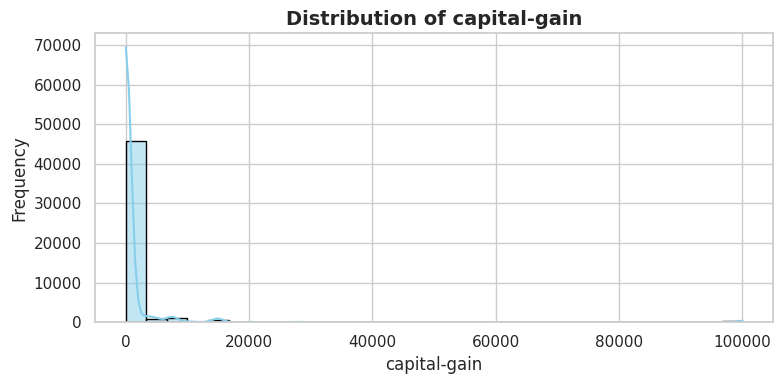

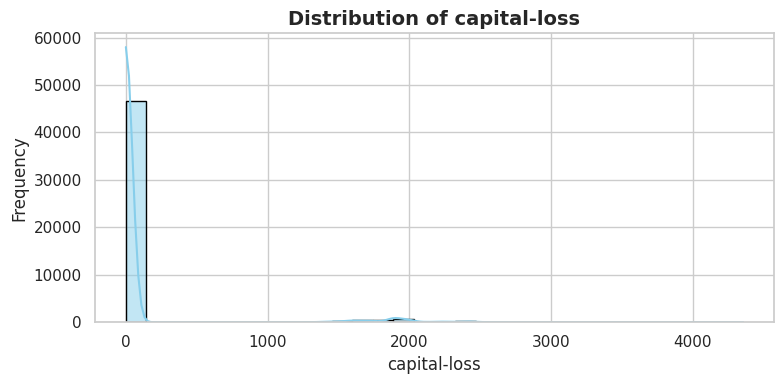

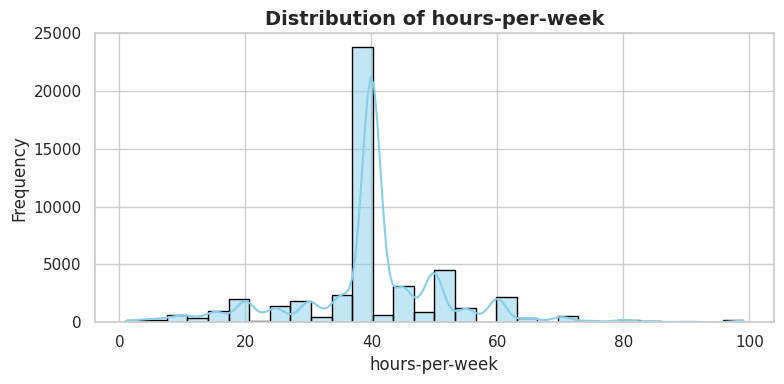

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"numerical_distributions_histograms/hist_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

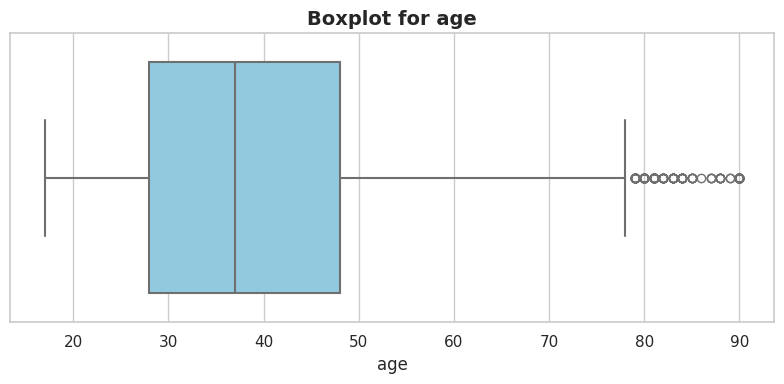

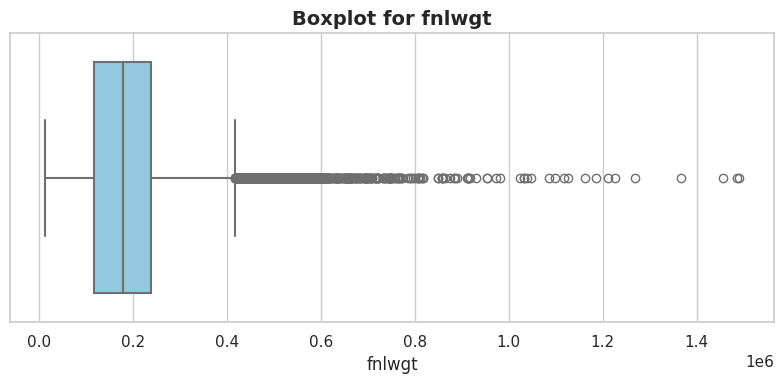

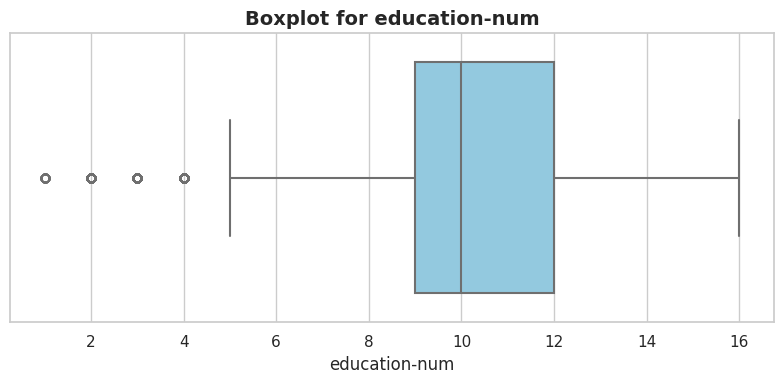

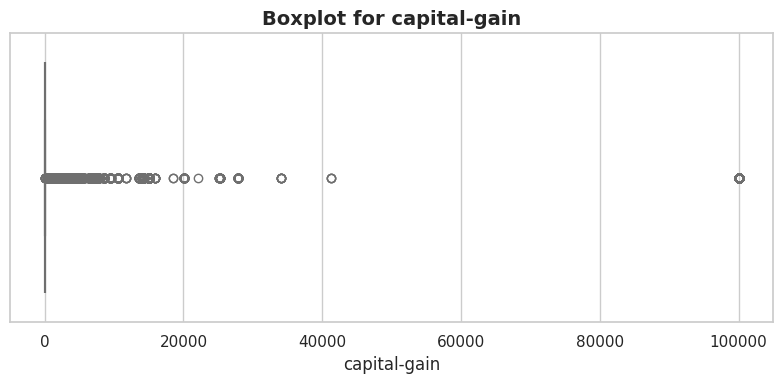

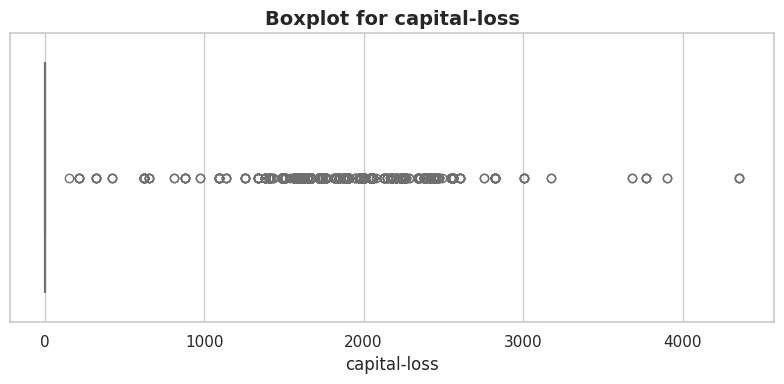

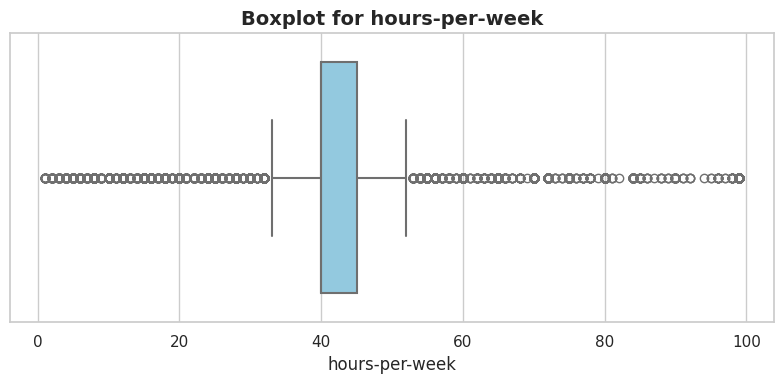

In [14]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='skyblue', linewidth=1.5)
    plt.title(f"Boxplot for {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"numerical_distributions_boxplots/boxplot_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

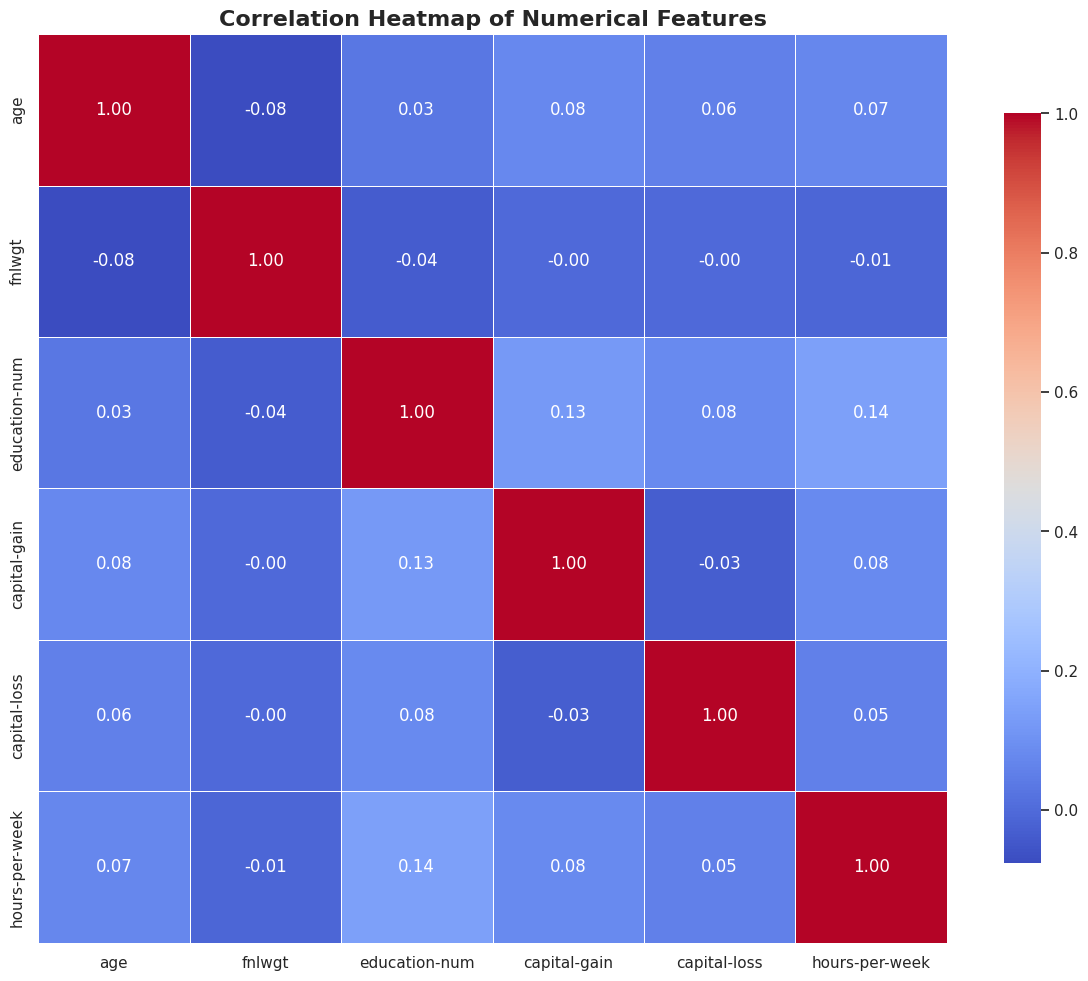

In [15]:
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
    square=True, cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()

# Log the figure directly to MLflow
mlflow.log_figure(plt.gcf(), "correlation_heatmap.png")

plt.show()
plt.close()

# EDA for Categorical Features

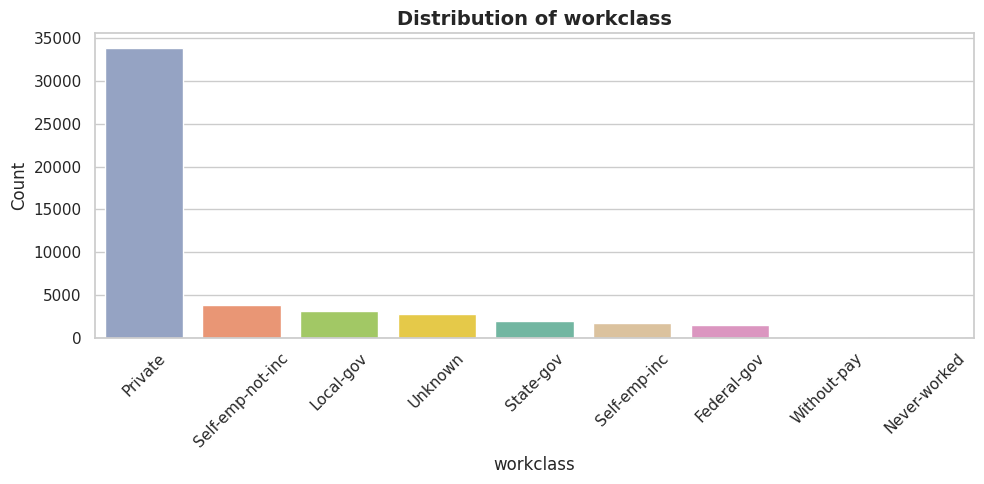

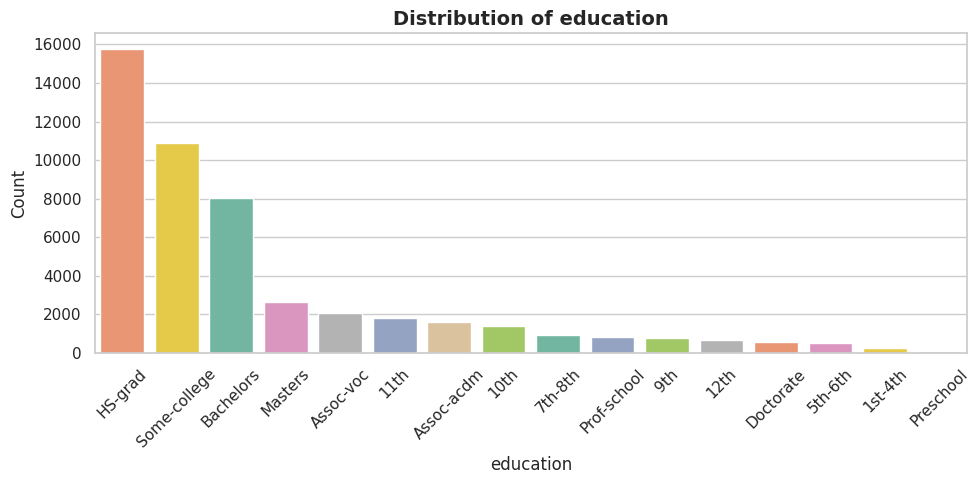

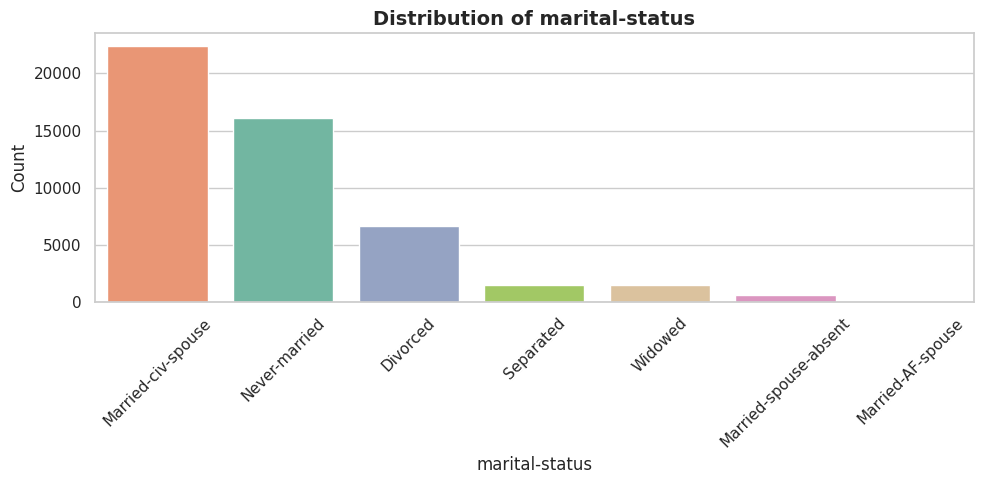

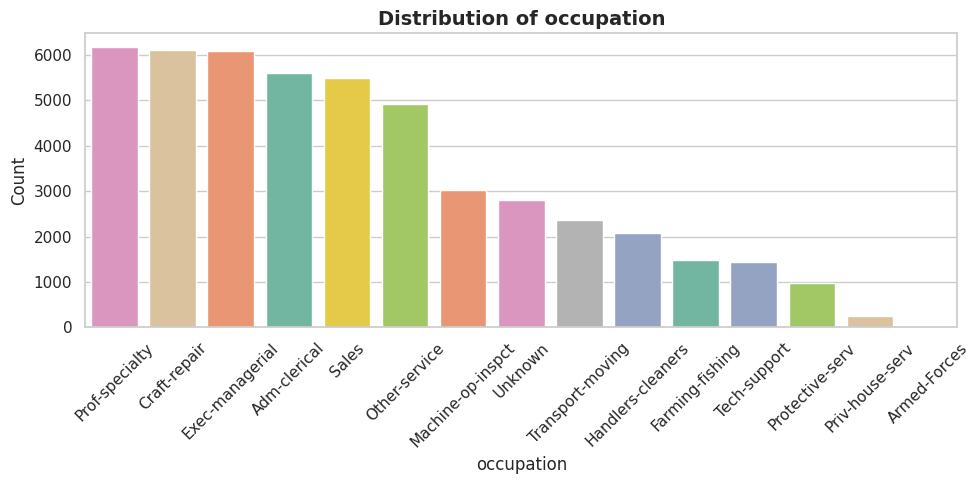

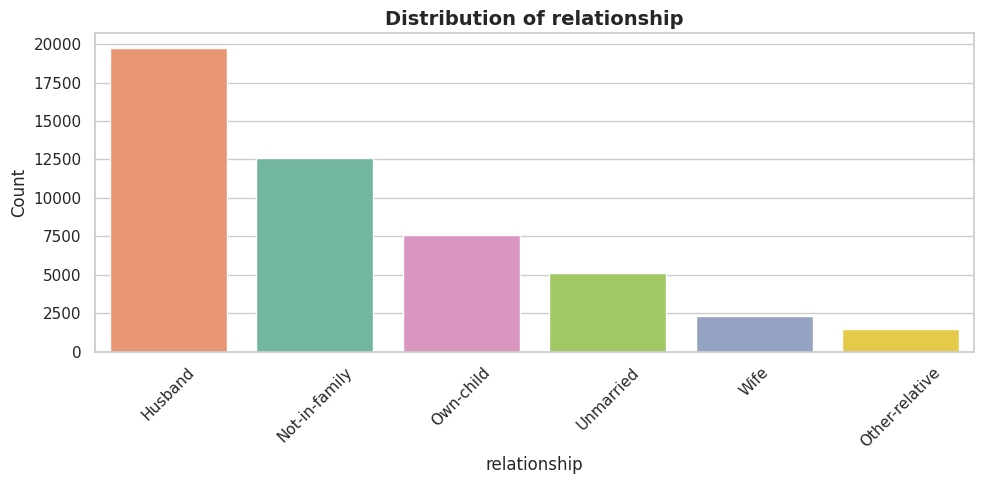

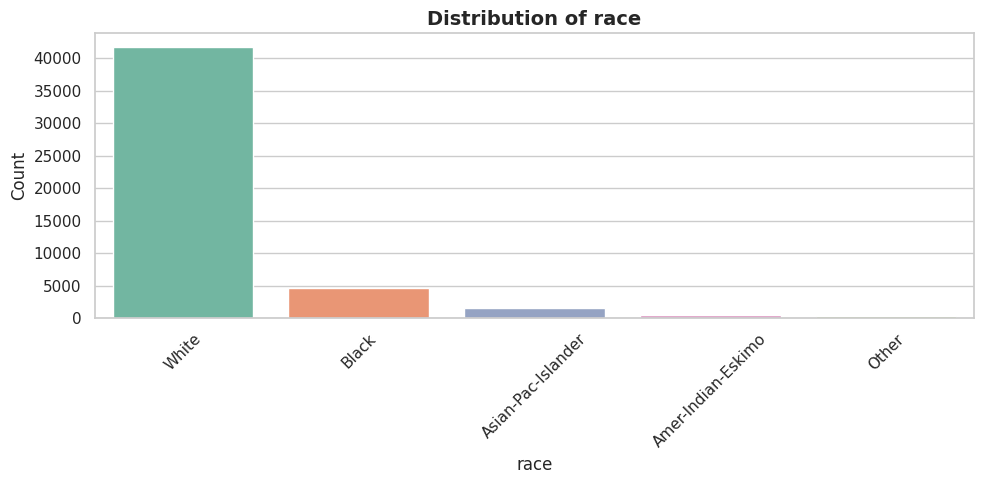

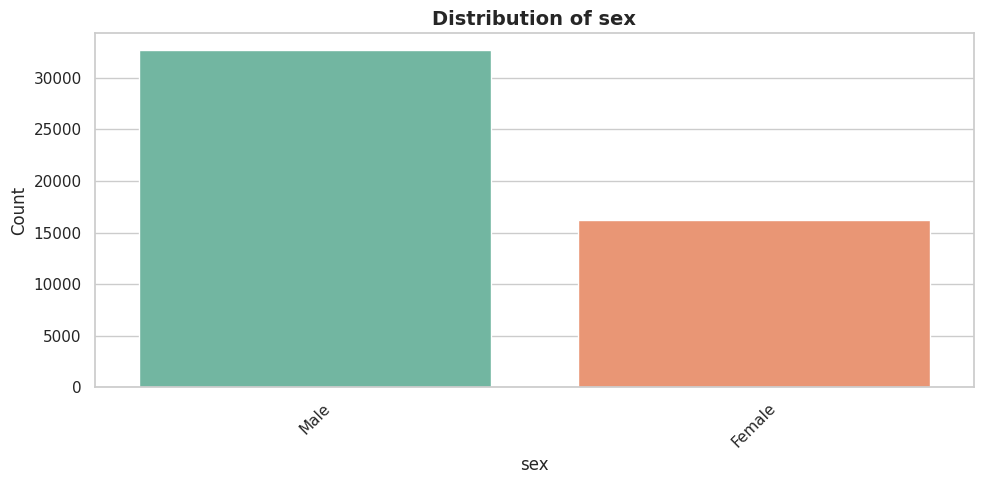

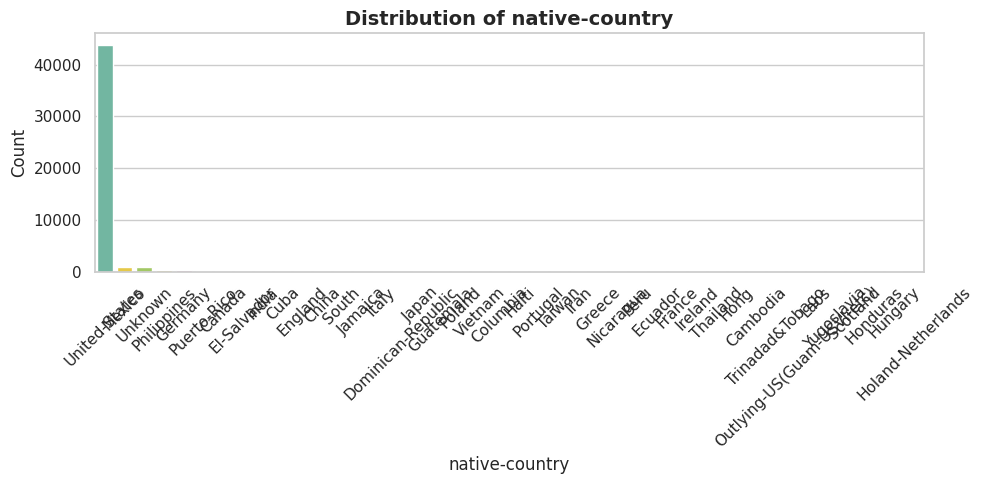

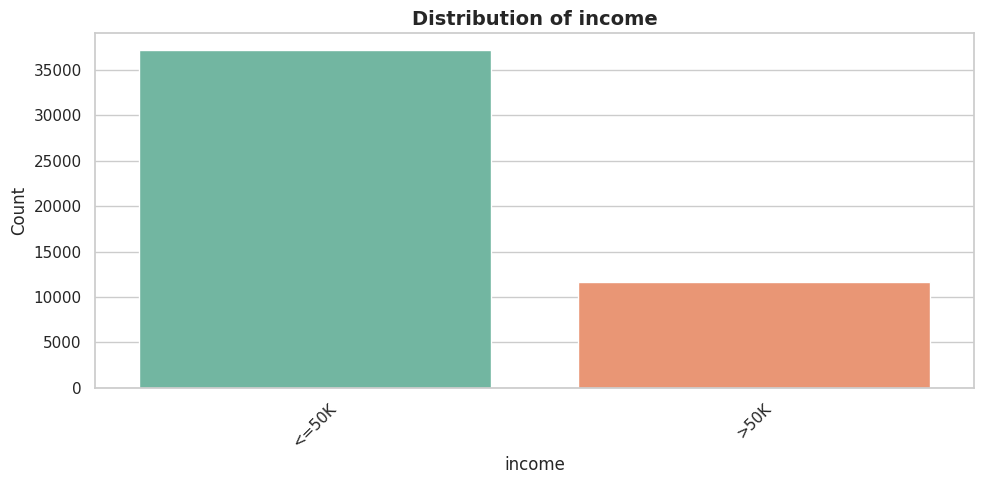

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

# Plot and log each categorical feature
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        data=df,
        x=col,
        hue=col,
        order=df[col].value_counts().index,
        palette="Set2",
        legend=False
    )
    plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log the figure directly to MLflow
    artifact_path = f"categorical_distributions/categorical_dist_{col}.png"
    mlflow.log_figure(plt.gcf(), artifact_path)

    plt.show()
    plt.close()

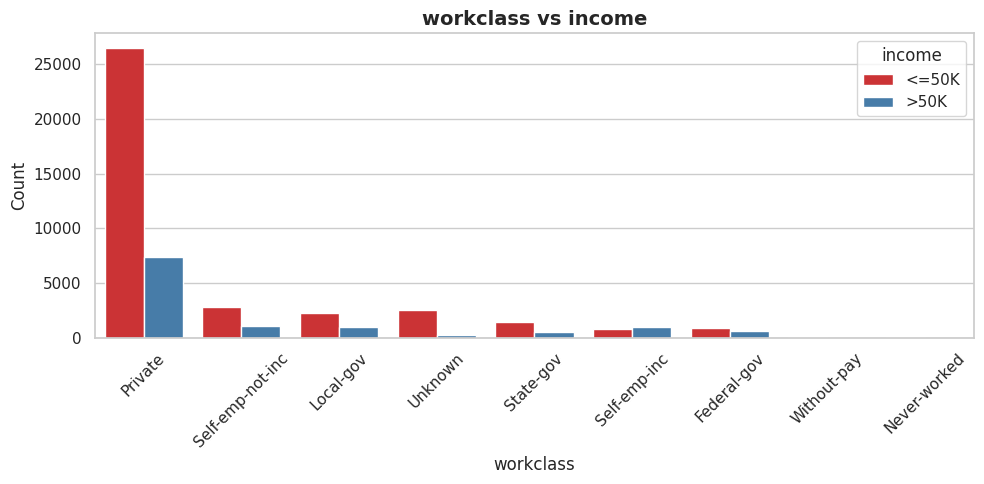

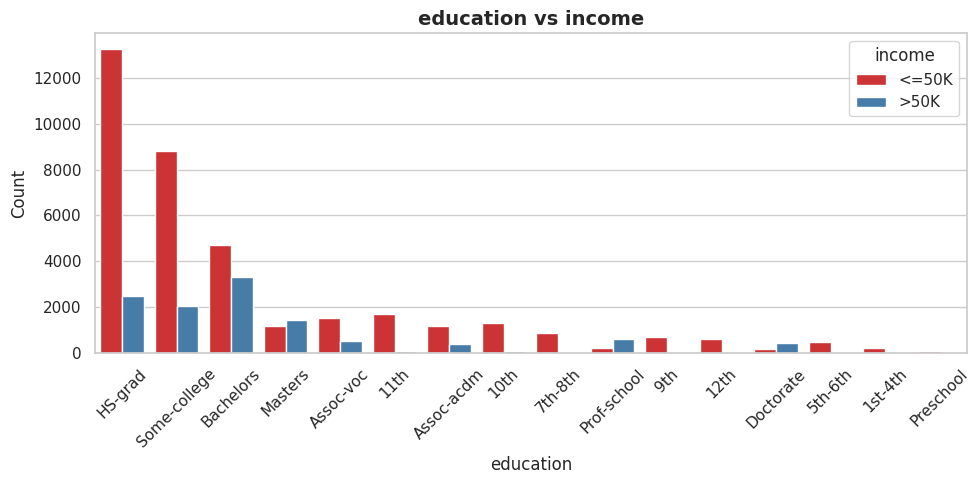

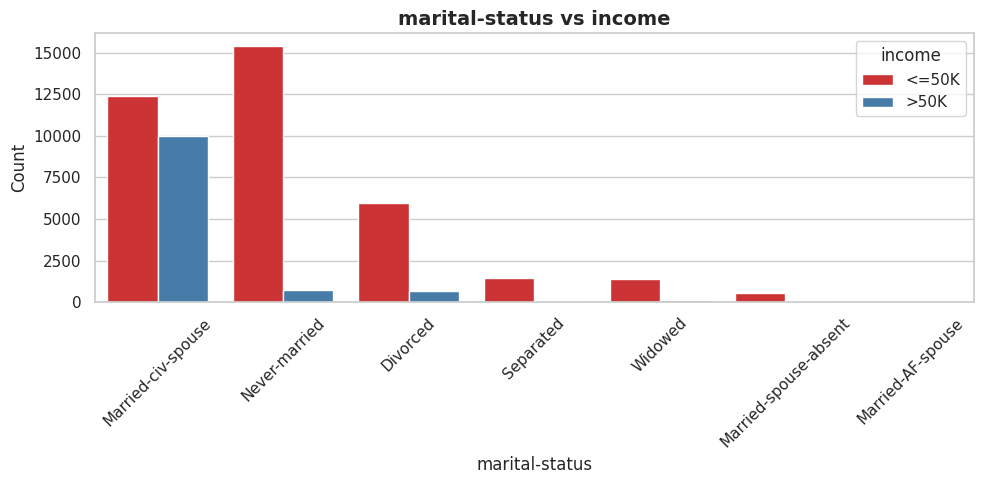

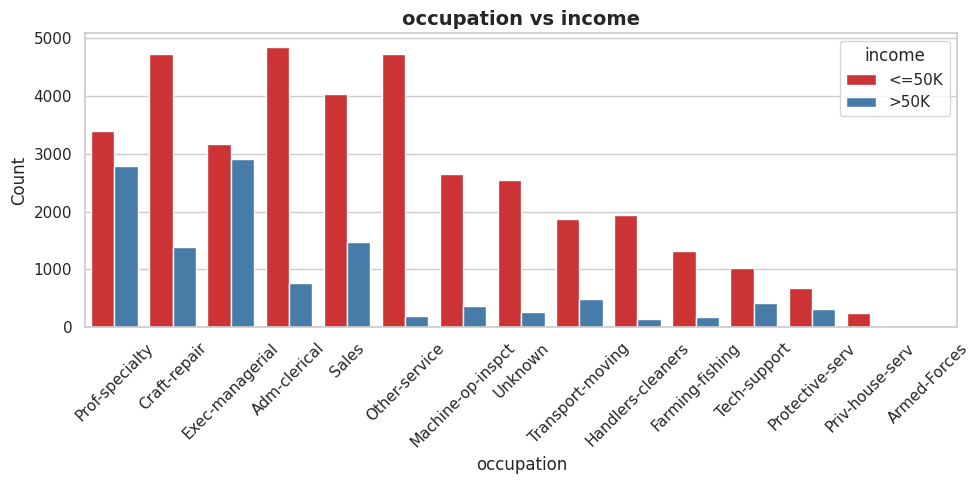

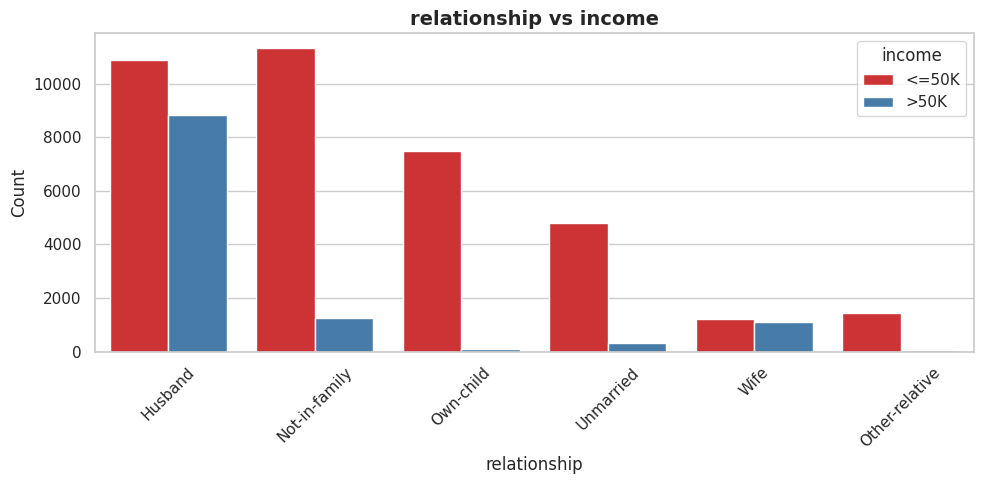

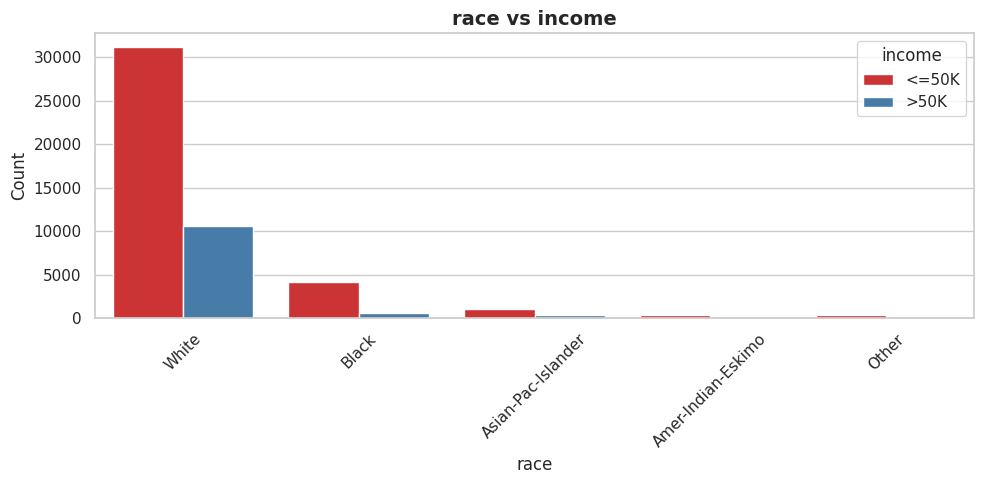

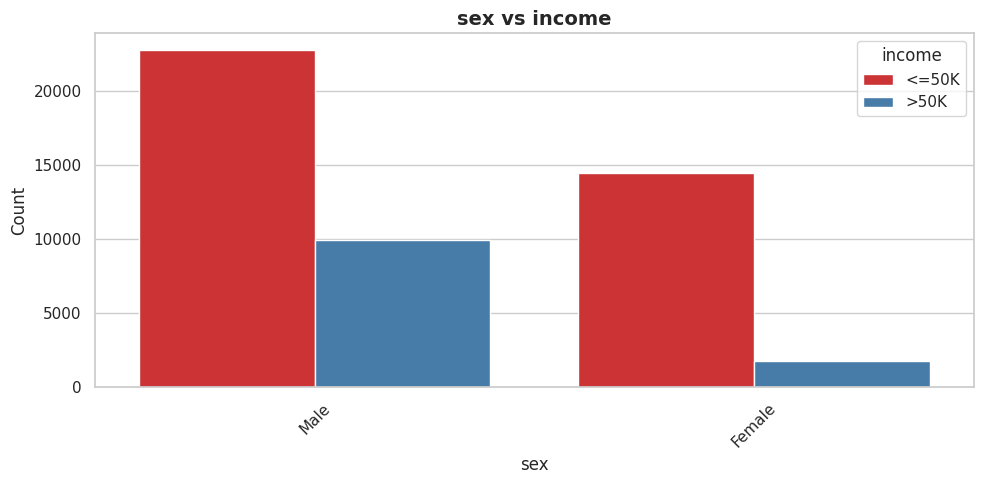

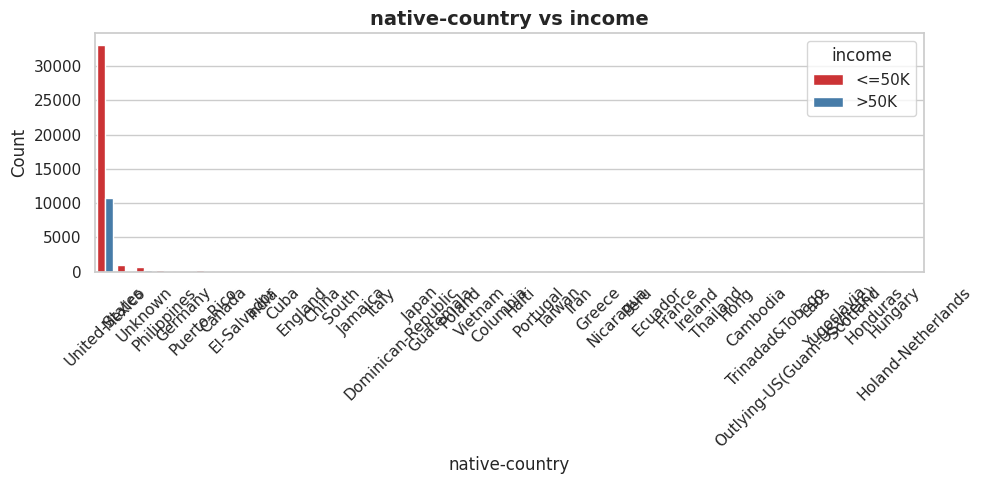

/tmp/ipykernel_761216/1032425529.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, loc='upper right')


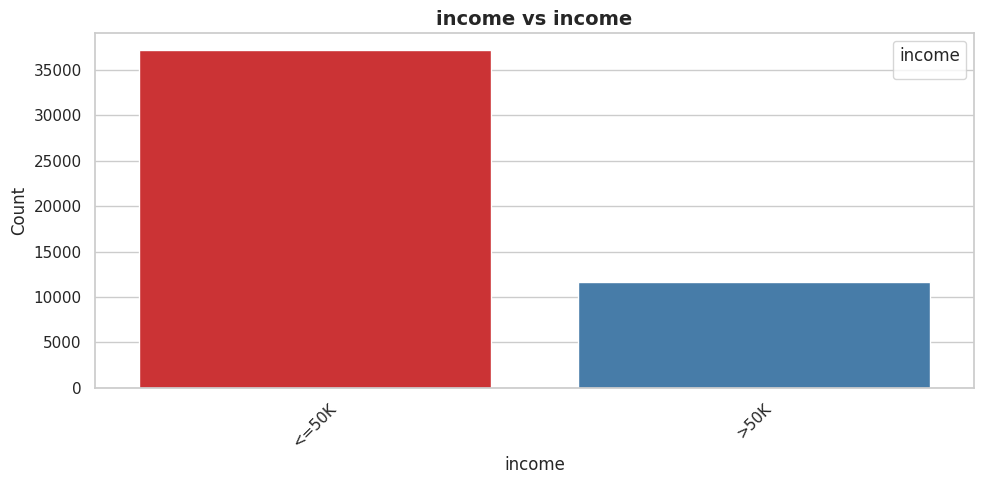

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

sns.set(style="whitegrid")

target_col = 'income'

if target_col in df.columns:
    for col in categorical_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(
            data=df,
            x=col,
            hue=target_col,
            order=df[col].value_counts().index,
            palette="Set1"
        )
        plt.title(f"{col} vs {target_col}", fontsize=14, fontweight='bold')
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title=target_col, loc='upper right')
        plt.tight_layout()

        # Log the figure directly to MLflow
        artifact_path = f"categorical_vs_target/{col}_vs_{target_col}.png"
        mlflow.log_figure(plt.gcf(), artifact_path)

        plt.show()
        plt.close()

# Data Transformation & Encoding

## Categorical Encoding

In [18]:
# One-Hot Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)
print("Data shape after encoding:", df_encoded.shape)


Data shape after encoding: (48842, 101)


In [19]:
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,38,215646,9,0,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,53,234721,7,0,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,28,338409,13,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,0,0,36,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48838,64,321403,9,0,0,40,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
48839,38,374983,13,0,0,50,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48840,44,83891,13,5455,0,40,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


In [20]:
# Log basic info
mlflow.log_params({
    "dataset_name": "adult",
    "no_of_cols": df.shape[1],
    "no_of_rows": df.shape[0],
    "columns": ','.join(df.columns.tolist()),
    "numerical_columns_count": df.select_dtypes(include='number').shape[1],
    "missing_values_total": int(df.isnull().sum().sum()),
    "target_column": "income",
    "categorical_columns_count": len(categorical_cols),
    "categorical_columns": ','.join(categorical_cols),
    "numerical_columns": ','.join(df.select_dtypes(include='number').columns.tolist()),
    "target_column_unique_values": df['income'].nunique(),
    "target_column_unique_values_list": ','.join(df['income'].unique().tolist()),
    "target_column_value_counts": df['income'].value_counts().to_dict(),
    "target_column_value_counts_percentage": df['income'].value_counts(normalize=True).to_dict()
})


In [21]:
# mlflow.log_params("Encoded Columns",','.join(df_encoded.columns.tolist()))
mlflow.log_param("Encoded Columns", ','.join(df_encoded.columns.tolist()))
mlflow.log_param("Encoded Columns Count", df_encoded.shape[1])
mlflow.log_param("Encoded Columns Shape", str(df_encoded.shape))

'(48842, 101)'

## Feature Scaling (Optional)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Apply scaling only to numerical columns (ensure column names match your post-encoding setup)
scaled_numerical = scaler.fit_transform(df_encoded[numerical_cols])
df_encoded[numerical_cols] = scaled_numerical


In [23]:
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.025996,0.243884,1.136512,-0.144804,-0.217127,-0.356894,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48838,1.849433,1.247492,-0.419335,-0.144804,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
48839,-0.046942,1.754865,1.136512,-0.144804,-0.217127,0.772930,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
48840,0.390683,-1.001612,1.136512,0.587220,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


# Splitting Data for Model Training

In [24]:
from sklearn.model_selection import train_test_split

# First, ensure the target variable has a clear name. Here we assume 'income' is the target.
# Adjust this to the actual target column name in your dataset.
target_col = 'income_>50K'
X_final = df_encoded.drop(columns=[target_col])
y_final = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (39073, 100)
Testing set shape: (9769, 100)


In [25]:
mlflow.log_params({
    "train_set_shape": str(X_train.shape),
    "test_set_shape": str(X_test.shape),
    "train_set_label_shape": str(y_train.shape),
    "test_set_label_shape": str(y_test.shape),
    "train_set_target_distribution": y_train.value_counts(normalize=True).to_dict(),
    "test_set_target_distribution": y_test.value_counts(normalize=True).to_dict()
})

In [26]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Unknown,native-country_Vietnam,native-country_Yugoslavia
37193,-0.484566,-1.315410,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
31093,0.463621,-0.429090,1.525474,-0.144804,-0.217127,-0.034087,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
33814,-0.265754,0.592340,-0.808297,-0.144804,-0.217127,-0.034087,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
14500,1.849433,-1.137649,-0.419335,-0.144804,-0.217127,-1.648120,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
23399,1.776496,-1.525072,-0.419335,-0.144804,-0.217127,2.386963,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.265754,0.098983,1.136512,-0.144804,4.465250,0.772930,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
44732,-1.286879,-0.935278,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
38158,-1.141004,1.708218,-0.419335,-0.144804,-0.217127,-0.034087,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
860,-1.505691,0.252075,-1.197259,-0.144804,-0.217127,-1.648120,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


In [27]:
import joblib
# Save to file
# Save as a tuple to a single .pkl file
joblib.dump((X_train, X_test, y_train, y_test), '../data/train_test_data.pkl')

['../data/train_test_data.pkl']

In [28]:
mlflow.end_run()

🏃 View run EDA at: http://0.0.0.0:5000/#/experiments/783964528290067990/runs/f8a66a451e01465c8fddb8e0930a87ac
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/783964528290067990


# Model Training - mlflow `autolog`

In [29]:
import joblib
import os
import mlflow
import mlflow.sklearn
import tempfile
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, average_precision_score
)

# Load environment variables
load_dotenv()
MLFLOW_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

# Set MLflow tracking
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult")

# Load the data
X_train, X_test, y_train, y_test = joblib.load('../data/train_test_data.pkl')

# Enable autologging
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="Logistic Regression Model Training - Autolog"):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Log the model
    print("accuracy_score(y_test, y_test_pred):", accuracy_score(y_test, y_test_pred))
    print("precision_score(y_test, y_test_pred):", precision_score(y_test, y_test_pred))
    print("recall_score(y_test, y_test_pred):", recall_score(y_test, y_test_pred))
    print("f1_score(y_test, y_test_pred):", f1_score(y_test, y_test_pred))
    print("log_loss(y_test, y_test_pred):", log_loss(y_test, y_test_pred_proba))
    print("roc_auc_score(y_test, y_test_pred):", roc_auc_score(y_test, y_test_pred_proba))
    print("pr_auc average_precision_score(y_test, y_test_pred):", average_precision_score(y_test, y_test_pred_proba))


accuracy_score(y_test, y_test_pred): 0.8511618384686253
precision_score(y_test, y_test_pred): 0.7428571428571429
recall_score(y_test, y_test_pred): 0.5851380042462845
f1_score(y_test, y_test_pred): 0.6546318289786224
log_loss(y_test, y_test_pred): 0.32065818472831303
roc_auc_score(y_test, y_test_pred): 0.9056374094571754
pr_auc average_precision_score(y_test, y_test_pred): 0.7669895482182756
🏃 View run Logistic Regression Model Training - Autolog at: http://0.0.0.0:5000/#/experiments/783964528290067990/runs/4e0d1321079748c8a7a9a3a4d94a1851
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/783964528290067990


# Model Training - mlflow `autolog` and mannal logging

In [30]:
import joblib
import os
import mlflow
import mlflow.sklearn
import tempfile
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, average_precision_score
)

# Load environment variables
load_dotenv()
MLFLOW_USERNAME = os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_PASSWORD = os.getenv('MLFLOW_TRACKING_PASSWORD')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

# Set MLflow tracking
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult")

# Load the data
X_train, X_test, y_train, y_test = joblib.load('../data/train_test_data.pkl')

# Enable autologging
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="Logistic Regression Model Training - Autolog and Manual"):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Train predictions
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Test metrics
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("test_precision", precision_score(y_test, y_test_pred))
    mlflow.log_metric("test_recall", recall_score(y_test, y_test_pred))
    mlflow.log_metric("test_f1_score", f1_score(y_test, y_test_pred))
    mlflow.log_metric("test_log_loss", log_loss(y_test, y_test_prob))
    mlflow.log_metric("test_roc_auc", roc_auc_score(y_test, y_test_prob))
    mlflow.log_metric("test_pr_auc", average_precision_score(y_test, y_test_prob))

    # Train metrics
    mlflow.log_metric("train_accuracy", accuracy_score(y_train, y_train_pred))
    mlflow.log_metric("train_precision", precision_score(y_train, y_train_pred))
    mlflow.log_metric("train_recall", recall_score(y_train, y_train_pred))
    mlflow.log_metric("train_f1_score", f1_score(y_train, y_train_pred))
    mlflow.log_metric("train_log_loss", log_loss(y_train, y_train_prob))
    mlflow.log_metric("train_roc_auc", roc_auc_score(y_train, y_train_prob))
    mlflow.log_metric("train_pr_auc", average_precision_score(y_train, y_train_prob))

    # # Confusion Matrix Values - TRAIN
    cm_train = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm_train.ravel()
    mlflow.log_metric("train_true_negative", tn)
    mlflow.log_metric("train_false_positive", fp)
    mlflow.log_metric("train_false_negative", fn)
    mlflow.log_metric("train_true_positive", tp)

    # Confusion Matrix Values - TEST
    cm_test = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm_test.ravel()
    mlflow.log_metric("test_true_negative", tn)
    mlflow.log_metric("test_false_positive", fp)
    mlflow.log_metric("test_false_negative", fn)
    mlflow.log_metric("test_true_positive", tp)


    # Plot and log confusion matrix for TRAIN
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Train")

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        mlflow.log_artifact(tmpfile.name, artifact_path="ConfusionMatrix")
    plt.close()

    # Plot and log confusion matrix for TEST
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Test")

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        mlflow.log_artifact(tmpfile.name, artifact_path="ConfusionMatrix")
    plt.close()


    # Train report
    train_report = classification_report(y_train, y_train_pred)
    with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".txt") as tmp:
        tmp.write(train_report)
        tmp.flush()
        mlflow.log_artifact(tmp.name, artifact_path="classification_report")

    # Test report
    test_report = classification_report(y_test, y_test_pred)
    with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".txt") as tmp:
        tmp.write(test_report)
        tmp.flush()
        mlflow.log_artifact(tmp.name, artifact_path="classification_report")


🏃 View run Logistic Regression Model Training - Autolog and Manual at: http://0.0.0.0:5000/#/experiments/783964528290067990/runs/4c728982683948d5938e7d62128519c0
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/783964528290067990


# ModelTrainer class for logging metrics and artifacts

In [31]:
import joblib
import mlflow
import mlflow.sklearn
import tempfile
import os
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, average_precision_score
)


class ModelTrainer:
    def __init__(self, model, model_name="Model", experiment_name="Default", run_name=None):
        self.model = model
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.run_name = run_name or f"{model_name} Training"
        mlflow.set_experiment(experiment_name)
        mlflow.sklearn.autolog()

    def _log_metrics(self, y_true, y_pred, y_prob, prefix):
        mlflow.log_metric(f"{prefix}_accuracy", accuracy_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_precision", precision_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_recall", recall_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_f1_score", f1_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_log_loss", log_loss(y_true, y_prob))
        mlflow.log_metric(f"{prefix}_roc_auc", roc_auc_score(y_true, y_prob))
        mlflow.log_metric(f"{prefix}_pr_auc", average_precision_score(y_true, y_prob))

        # Confusion matrix raw values
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metric(f"{prefix}_true_negative", tn)
        mlflow.log_metric(f"{prefix}_false_positive", fp)
        mlflow.log_metric(f"{prefix}_false_negative", fn)
        mlflow.log_metric(f"{prefix}_true_positive", tp)

        return cm

    def _log_confusion_matrix(self, cm, title, artifact_name):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            plt.savefig(tmpfile.name)
            mlflow.log_artifact(tmpfile.name, artifact_path="confusion_matrices")
        plt.close()

    def _log_classification_report(self, y_true, y_pred, prefix):
        report = classification_report(y_true, y_pred)
        with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".txt") as tmpfile:
            tmpfile.write(report)
            tmpfile.flush()
            mlflow.log_artifact(tmpfile.name, artifact_path="classification_reports")

    def train_and_log(self, X_train, X_test, y_train, y_test):
        with mlflow.start_run(run_name=self.run_name):
            self.model.fit(X_train, y_train)

            # Train predictions
            y_train_pred = self.model.predict(X_train)
            y_train_prob = self.model.predict_proba(X_train)[:, 1]

            # Test predictions
            y_test_pred = self.model.predict(X_test)
            y_test_prob = self.model.predict_proba(X_test)[:, 1]

            # Log train/test metrics
            cm_train = self._log_metrics(y_train, y_train_pred, y_train_prob, "train")
            cm_test = self._log_metrics(y_test, y_test_pred, y_test_prob, "test")

            # Log confusion matrices
            self._log_confusion_matrix(cm_train, "Confusion Matrix - Train", "confusion_matrix_train")
            self._log_confusion_matrix(cm_test, "Confusion Matrix - Test", "confusion_matrix_test")

            # Log classification reports
            self._log_classification_report(y_train, y_train_pred, "train")
            self._log_classification_report(y_test, y_test_pred, "test")

In [32]:
from dotenv import load_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import joblib
import os

# Load environment variables
load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))

# Load data
X_train, X_test, y_train, y_test = joblib.load("../data/train_test_data.pkl")

# Models config
models = [
    ("LogisticRegression_C_0_1", LogisticRegression(max_iter=2000, solver="liblinear", C=0.1)),
    ("LogisticRegression_C_1_0", LogisticRegression(max_iter=2000, solver="liblinear", C=1.0)),
    ("LogisticRegression_C_10_0", LogisticRegression(max_iter=2000, solver="liblinear", C=10.0)),
    ("RandomForest_n200_md10", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ("RandomForest_n100_md5", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ("RandomForest_n300_md15", RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)),
    ("XGBoost_default", XGBClassifier(eval_metric="logloss", random_state=42)),
    ("XGBoost_lr01_md3", XGBClassifier(learning_rate=0.1, max_depth=3, eval_metric="logloss", random_state=42)),
    ("XGBoost_lr005_md5", XGBClassifier(learning_rate=0.05, max_depth=5, eval_metric="logloss", random_state=42)),
    ("KNN_n5_minkowski", KNeighborsClassifier(n_neighbors=5, metric='minkowski')),
    ("KNN_n10_euclidean", KNeighborsClassifier(n_neighbors=10, metric='euclidean')),
    ("KNN_n3_manhattan", KNeighborsClassifier(n_neighbors=3, metric='manhattan')),
    ("GradientBoosting_n150_lr01_md5", GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)),
    ("GradientBoosting_n100_lr005_md3", GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)),
    ("GradientBoosting_n200_lr02_md7", GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=7, random_state=42)),
]

# Loop through and train each model
for model_name, model in models:
    print(f"🏃 Training {model_name}")
    trainer = ModelTrainer(
        model=model,
        model_name=model_name,
        experiment_name="Adult_sklearn_mdoels"
    )
    trainer.train_and_log(X_train, X_test, y_train, y_test)

2025/04/16 23:46:58 INFO mlflow.tracking.fluent: Experiment with name 'Adult_sklearn_mdoels' does not exist. Creating a new experiment.


🏃 Training LogisticRegression_C_0_1
🏃 View run LogisticRegression_C_0_1 Training at: http://0.0.0.0:5000/#/experiments/796860261230010581/runs/774fc9ab72904445800954bfee99c778
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/796860261230010581
🏃 Training LogisticRegression_C_1_0
🏃 View run LogisticRegression_C_1_0 Training at: http://0.0.0.0:5000/#/experiments/796860261230010581/runs/d0a1ab998e7645f7833b2ab35ef0f818
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/796860261230010581
🏃 Training LogisticRegression_C_10_0
🏃 View run LogisticRegression_C_10_0 Training at: http://0.0.0.0:5000/#/experiments/796860261230010581/runs/d3dd460f247e43a9a49a65838f3d4f9e
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/796860261230010581
🏃 Training RandomForest_n200_md10
🏃 View run RandomForest_n200_md10 Training at: http://0.0.0.0:5000/#/experiments/796860261230010581/runs/b9bee5e499394d28a11b3cac345d13a1
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/79686026123001058

In [33]:
import os
import joblib
import mlflow
import mlflow.tensorflow
from mlflow.models.signature import infer_signature
import numpy as np
import tempfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from dotenv import load_dotenv
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Load env vars and MLflow setup
load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("Adult")

# Load preprocessed data
X_train, X_test, y_train, y_test = joblib.load("../data/train_test_data.pkl")

# Make sure y is 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Enable MLflow autologging for TensorFlow
mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="Deep Neural Network - TensorFlow"):
    # Build DNN
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,               # Wait for 5 epochs of no improvement
        restore_best_weights=True # Roll back to the best model
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,              
        batch_size=64,
        callbacks=[early_stop], 
        verbose=1
    )

    # Predictions
    y_train_prob = model.predict(X_train).ravel()
    y_test_prob = model.predict(X_test).ravel()
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)


    # Metrics function
    def log_metrics(y_true, y_pred, y_prob, prefix):
        mlflow.log_metric(f"{prefix}_accuracy", accuracy_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_precision", precision_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_recall", recall_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_f1_score", f1_score(y_true, y_pred))
        mlflow.log_metric(f"{prefix}_log_loss", log_loss(y_true, y_prob))
        mlflow.log_metric(f"{prefix}_roc_auc", roc_auc_score(y_true, y_prob))
        mlflow.log_metric(f"{prefix}_pr_auc", average_precision_score(y_true, y_prob))

        # Confusion matrix counts
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        mlflow.log_metric(f"{prefix}_true_negative", tn)
        mlflow.log_metric(f"{prefix}_false_positive", fp)
        mlflow.log_metric(f"{prefix}_false_negative", fn)
        mlflow.log_metric(f"{prefix}_true_positive", tp)

    # Log train and test metrics
    log_metrics(y_train, y_train_pred, y_train_prob, "train")
    log_metrics(y_test, y_test_pred, y_test_prob, "test")

    # Log confusion matrix plots
    for prefix, y_true, y_pred in [
        ("Train", y_train, y_train_pred),
        ("Test", y_test, y_test_pred)
    ]:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {prefix}")
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            plt.savefig(tmpfile.name)
            mlflow.log_artifact(tmpfile.name, artifact_path="confusion_matrices")
        plt.close()

    # Log classification reports
    for prefix, y_true, y_pred in [
        ("train", y_train, y_train_pred),
        ("test", y_test, y_test_pred)
    ]:
        report = classification_report(y_true, y_pred)
        with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".txt") as tmpfile:
            tmpfile.write(report)
            tmpfile.flush()
            mlflow.log_artifact(tmpfile.name, artifact_path="classification_reports")

2025-04-16 23:53:59.972716: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 23:53:59.973706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 23:53:59.977072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 23:53:59.984058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744827839.996000  761216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744827839.99

Epoch 1/100
610/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.3877

611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8179 - loss: 0.3876 - val_accuracy: 0.8535 - val_loss: 0.3140
Epoch 2/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.3120

611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8537 - loss: 0.3120 - val_accuracy: 0.8559 - val_loss: 0.3122
Epoch 3/100
597/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3079

611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8603 - loss: 0.3080 - val_accuracy: 0.8557 - val_loss: 0.3122
Epoch 4/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8560 - loss: 0.3096

611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8560 - loss: 0.3096 - val_accuracy: 0.8561 - val_loss: 0.3107
Epoch 5/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8609 - loss: 0.3064 - val_accuracy: 0.8566 - val_loss: 0.3109
Epoch 6/100
597/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.3030

611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8600 - loss: 0.3031 - val_accuracy: 0.8562 - val_loss: 0.3104
Epoch 7/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8614 - loss: 0.2997 - val_accuracy: 0.8579 - val_loss: 0.3106
Epoch 8/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8626 - loss: 0.3011 - val_accuracy: 0.8537 - val_loss: 0.3138
Epoch 9/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8650 - loss: 0.2965 - val_accuracy: 0.8577 - val_loss: 0.3117
Epoch 10/100
610/611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.2983

611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8640 - loss: 0.2983 - val_accuracy: 0.8599 - val_loss: 0.3095
Epoch 11/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8659 - loss: 0.2914 - val_accuracy: 0.8590 - val_loss: 0.3096
Epoch 12/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8677 - loss: 0.2892 - val_accuracy: 0.8592 - val_loss: 0.3113
Epoch 13/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8659 - loss: 0.2916 - val_accuracy: 0.8589 - val_loss: 0.3123
Epoch 14/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8657 - loss: 0.2875 - val_accuracy: 0.8595 - val_loss: 0.3119
Epoch 15/100
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8654 - loss: 0.2901 - val_accuracy: 0.8574 - val_loss: 0.3152


2025/04/16 23:54:27 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/04/16 23:54:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/16 23:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
🏃 View run Deep Neural Network - TensorFlow at: http://0.0.0.0:5000/#/experiments/783964528290067990/runs/46147c343cb84862b0a9ff32ba9e95a7
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/783964528290067990


# Hyperparameter Tuning

In [34]:
import numpy as np
import mlflow
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment("CaliforniaHousing - Hyperparameter Tuning")

2025/04/16 23:54:36 INFO mlflow.tracking.fluent: Experiment with name 'CaliforniaHousing - Hyperparameter Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/tharindu/repos/mlflow_iris_example/mlflow/mlruns/113691782086194057', creation_time=1744827876120, experiment_id='113691782086194057', last_update_time=1744827876120, lifecycle_stage='active', name='CaliforniaHousing - Hyperparameter Tuning', tags={}>

In [35]:

def tune_and_log_model(model_name, model_class, param_grid):
    print(f"🔍 Tuning {model_name}...")

    # Create grid search
    grid_search = GridSearchCV(
        estimator=model_class,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name):
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Predictions
        preds = best_model.predict(X_test_scaled)

        # Log best hyperparameters
        mlflow.log_params(best_params)

        # Evaluate and log metrics
        evaluate_and_log(model_name, y_test, preds)

        # Log the model with signature
        from mlflow.models.signature import infer_signature
        input_example = pd.DataFrame(X_train_scaled[:5], columns=X_train.columns)
        signature = infer_signature(X_train_scaled, best_model.predict(X_train_scaled))
        mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=input_example)

        print(f"✅ Best params for {model_name}: {best_params}")

In [36]:
tune_and_log_model(
    model_name="Ridge",
    model_class=Ridge(),
    param_grid={
        "alpha": [0.01, 0.1, 1.0, 10.0],
        "solver": ["auto", "sag", "cholesky"]  # Changed problematic solver
        # Alternatively, add "positive": [True] if you want to use 'lbfgs'
    }
)

NameError: name 'Ridge' is not defined

In [ ]:
from sklearn.svm import SVR

tune_and_log_model(
    model_name="SVR",
    model_class=SVR(),
    param_grid={
        "C": [0.1, 1.0, 10.0],
        "kernel": ["linear", "rbf"],
        "epsilon": [0.01, 0.1, 0.2]
    }
)

🔍 Tuning SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5] END C=0.1, epsilon=0.2, kernel=linear;, score=(train=-0.494, test=-0.474) total time=  21.8s
[CV 1/5] END C=0.1, epsilon=0.2, kernel=linear;, score=(train=-0.490, test=-0.492) total time=  24.3s
[CV 1/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.492, test=-0.495) total time=  23.6s
[CV 2/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.497, test=-0.477) total time=  25.7s
[CV 4/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.496, test=-0.476) total time=  26.8s
[CV 5/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.480, test=-0.538) total time=  30.4s
[CV 5/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.480, test=-0.540) total time=  29.4s
[CV 2/5] END C=0.1, epsilon=0.1, kernel=linear;, score=(train=-0.496, test=-0.476) total time=  30.8s
[CV 3/5] END C=0.1, epsilon=0.01, kernel=linear;, score=(train=-0.496, test=-0.484) total time=  27.6s
[C

In [ ]:
from sklearn.ensemble import RandomForestRegressor

tune_and_log_model(
    model_name="RandomForest_Extended",
    model_class=RandomForestRegressor(random_state=42),
    param_grid={
        "n_estimators": [100, 200, 300],  # Add higher values
        "max_depth": [None, 15, 20],  # Keep None and try larger depths
        "min_samples_split": [2, 4, 8],  # More granular values
        "min_samples_leaf": [1, 2, 4],  # Add this parameter
        "max_features": ["sqrt", "log2", None]  # Add feature selection parameter
    }
)

🔍 Tuning RandomForest_Extended...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=-0.048, test=-0.252) total time=   5.9s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.036, test=-0.253) total time=   6.0s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.035, test=-0.250) total time=   6.0s
[CV 4/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=-0.035, test=-0.245) total time=   6.0s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=-0.047, test=-0.253) total time=   6.5s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estima

/home/tharindu/repos/mlflow_iris_example/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=(train=-0.047, test=-0.248) total time=  21.7s
[CV 5/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=-0.034, test=-0.250) total time=  30.8s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=-0.034, test=-0.249) total time=  30.9s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=-0.065, test=-0.255) total time=   7.9s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200;, score=(train=-0.074, test=-0.252) total time=  17.0s
[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=-0.066, test=-0.257) total time=   9.2s
[CV 1/5] END max_depth=None, max_f

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

tune_and_log_model(
    model_name="GradientBoosting-v2",
    model_class=GradientBoostingRegressor(random_state=42),
    param_grid={
        "n_estimators": [100, 150, 200, 250],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5, 8, 10]
    }
)

🔍 Tuning GradientBoosting-v2...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.305, test=-0.333) total time=   3.4s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.306, test=-0.330) total time=   3.3s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.306, test=-0.322) total time=   3.4s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.307, test=-0.342) total time=   3.4s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=100;, score=(train=-0.312, test=-0.312) total time=   3.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0.275, test=-0.306) total time=   5.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0.278, test=-0.287) total time=   5.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=150;, score=(train=-0

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

tune_and_log_model(
    model_name="GradientBoosting-v3",
    model_class=GradientBoostingRegressor(random_state=42),
    param_grid={
        "n_estimators": [250, 350, 500],
        "learning_rate": [0.08, 0.1, 0.15],
        "max_depth": [8, 10, 12],
        "min_samples_split": [2, 5],
        "subsample": [0.8, 1.0]
    }
)

🔍 Tuning GradientBoosting-v3...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 5/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=0.8;, score=(train=-0.023, test=-0.217) total time=  36.8s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=0.8;, score=(train=-0.024, test=-0.213) total time=  40.1s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.025, test=-0.217) total time=  44.5s
[CV 1/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.026, test=-0.216) total time=  44.9s
[CV 5/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=250, subsample=1.0;, score=(train=-0.027, test=-0.224) total time=  49.7s
[CV 3/5] END learning_rate=0.08, max_depth=8, min_samples_split=2, n_estimators=350, subsample=0.8;, score=(train=-0.014, test=-0.213) 

In [ ]:
from sklearn.linear_model import LinearRegression

tune_and_log_model(
    model_name="LinearRegression",
    model_class=LinearRegression(),
    param_grid={
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "positive": [False, True]  # Constrains coefficients to be positive
    }
)

🔍 Tuning LinearRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.630, test=-0.637) total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.479, test=-0.462) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.478, test=-0.470) total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.628, test=-0.646) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=True;, score=(train=-0.637, test=-0.612) total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.479, test=-0.461) total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.464, test=-0.527) total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, positive=False;, score=(train=-0.476, test=-0.477) total

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

tune_and_log_model(
    model_name="KNN",
    model_class=KNeighborsRegressor(),
    param_grid={
        "n_neighbors": [3, 5, 7, 9, 11, 15],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "p": [1, 2]  # 1 for Manhattan distance, 2 for Euclidean
    }
)

🔍 Tuning KNN...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 3/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.205, test=-0.399) total time=   0.2s
[CV 3/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.397) total time=   0.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.417) total time=   0.3s
[CV 2/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.381) total time=   0.2s
[CV 2/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.202, test=-0.384) total time=   0.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, p=2, weights=uniform;, score=(train=-0.202, test=-0.419) total time=   0.3s
[CV 4/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(train=-0.000, test=-0.389) total time=   0.3s
[CV 5/5] END algorithm=auto, n_neighbors=3, p=2, weights=distance;, score=(tra

In [ ]:
from sklearn.linear_model import Lasso

tune_and_log_model(
    model_name="Lasso",
    model_class=Lasso(random_state=42, max_iter=5000),
    param_grid={
        "alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 10.0],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"],
        "tol": [1e-3, 1e-4]
    }
)

🔍 Tuning Lasso...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 3/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.478, test=-0.469) total time=   0.0s
[CV 2/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.479, test=-0.462) total time=   0.0s
[CV 4/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.479, test=-0.462) total time=   0.0s[CV 2/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.0001;, score=(train=-0.479, test=-0.462) total time=   0.0s

[CV 5/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.464, test=-0.525) total time=   0.0s
[CV 1/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.001;, score=(train=-0.476, test=-0.477) total time=   0.0s
[CV 3/5] END alpha=0.001, fit_intercept=True, selection=cyclic, tol=0.0001;, score=(train=-0.478, test=-0.469) total time=   0.0s
[CV 1/5] END al

# `hyperopt` HPO for DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# --- Evaluation Function ---
def evaluate_and_log(prefix, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    print(f"{prefix} Metrics: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    if mlflow.active_run():
        mlflow.log_metric(f"{prefix}_mae", mae)
        mlflow.log_metric(f"{prefix}_rmse", rmse)
        mlflow.log_metric(f"{prefix}_r2", r2)
    return {"mae": mae, "rmse": rmse, "r2": r2}

# --- HPO Objective Function ---
HPO_EXPERIMENT_NAME = "CaliforniaHousing_DNN_HPO_MSE"
mlflow.set_experiment(HPO_EXPERIMENT_NAME)

def objective_mse(params):
    run_timestamp = time.strftime("%Y%m%d_%H%M%S")
    trial_run_name = f"Trial_MSE_{run_timestamp}_{int(time.time() * 1000)}"

    with mlflow.start_run(run_name=trial_run_name, nested=True):
        mlflow.log_params(params)
        print(f"\nStarting Trial: {trial_run_name} with params: {params}")

        model = Sequential([
            Dense(params['units1'], activation='relu', input_shape=(input_dim,)),
            Dense(params['units2'], activation='relu'),
            Dense(1)
        ])

        if params['optimizer'] == 'adam':
            optimizer = Adam(learning_rate=params['learning_rate'])
        else:
            optimizer = RMSprop(learning_rate=params['learning_rate'])

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            mode='min',
            verbose=0
        )

        history = model.fit(
            X_train_scaled, y_train,
            epochs=100,
            batch_size=params['batch_size'],
            validation_data=(X_test_scaled, y_test),
            callbacks=[early_stopping],
            verbose=2
        )

        if 'val_loss' in history.history and history.history['val_loss']:
            min_val_loss = min(history.history['val_loss'])
            best_epoch = np.argmin(history.history['val_loss']) + 1
            print(f"Trial completed. Best val_loss: {min_val_loss:.4f} at epoch {best_epoch}")
            mlflow.log_metric("best_val_loss", min_val_loss)
            mlflow.log_metric("best_epoch", best_epoch)

            if 'val_mae' in history.history and len(history.history['val_mae']) > np.argmin(history.history['val_loss']):
                corresponding_val_mae = history.history['val_mae'][np.argmin(history.history['val_loss'])]
                mlflow.log_metric("corresponding_val_mae_at_best_loss", corresponding_val_mae)
        else:
            print("Warning: 'val_loss' not found in history. Setting loss to infinity.")
            min_val_loss = float('inf')
            mlflow.log_metric("best_val_loss", min_val_loss)

        return {'loss': min_val_loss, 'status': STATUS_OK, 'model': model}

# --- Hyperparameter Search Space ---
space = {
    'units1': hp.choice('units1', [128, 256, 384, 512, 768, 1024]),
    'units2': hp.choice('units2', [64, 128, 192, 256, 384, 512]),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(5e-3)),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop'])
}

# --- Run HPO ---
trials = Trials()
print("\nStarting hyperparameter optimization using validation MSE on the test set...")

if 'X_train_scaled' not in globals() or 'y_train' not in globals():
     raise NameError("Training data is not defined.")

best_result = fmin(
    fn=objective_mse,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("-" * 30)
print("HPO finished. Best parameter indices:")
print(best_result)

# --- Decode Best Hyperparameter Indices ---
choice_units1 = [128, 256, 384, 512, 768, 1024]
choice_units2 = [64, 128, 192, 256, 384, 512]
choice_batch_size = [32, 64, 128]
choice_optimizer = ['adam', 'rmsprop']

best_params = {
    'units1': choice_units1[best_result['units1']],
    'units2': choice_units2[best_result['units2']],
    'batch_size': choice_batch_size[best_result['batch_size']],
    'learning_rate': best_result['learning_rate'],
    'optimizer': choice_optimizer[best_result['optimizer']]
}

print("\nDecoded Best Parameters:")
print(best_params)
print("-" * 30)

# --- Final Model Training and Logging ---
BEST_MODEL_EXPERIMENT_NAME = "CaliforniaHousing - Hyperparameter Tuning"
BEST_MODEL_RUN_NAME = "Best_DNN_Regressor_from_HPO_MSE"

mlflow.set_experiment(BEST_MODEL_EXPERIMENT_NAME)

with mlflow.start_run(run_name=BEST_MODEL_RUN_NAME):
    print(f"\nTraining final model using test set for validation...")
    mlflow.log_params(best_params)

    final_model = Sequential([
        Dense(best_params['units1'], activation='relu', input_shape=(input_dim,)),
        Dense(best_params['units2'], activation='relu'),
        Dense(1)
    ])

    final_optimizer = Adam(learning_rate=best_params['learning_rate']) if best_params['optimizer'] == 'adam' \
        else RMSprop(learning_rate=best_params['learning_rate'])

    final_model.compile(optimizer=final_optimizer, loss='mse', metrics=['mae'])

    final_early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    final_history = final_model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=best_params['batch_size'],
        validation_data=(X_test_scaled, y_test),
        callbacks=[final_early_stopping],
        verbose=2
    )

    best_final_epoch = np.argmin(final_history.history['val_loss'])
    mlflow.log_metric("final_train_loss", final_history.history['loss'][best_final_epoch])
    mlflow.log_metric("final_train_mae", final_history.history['mae'][best_final_epoch])
    mlflow.log_metric("final_val_loss", final_history.history['val_loss'][best_final_epoch])
    mlflow.log_metric("final_val_mae", final_history.history['val_mae'][best_final_epoch])
    mlflow.log_metric("final_best_epoch", best_final_epoch + 1)

    print("\nEvaluating final model on Test Set:")
    test_preds = final_model.predict(X_test_scaled).flatten()
    evaluate_and_log("Test", y_test, test_preds)

    print("Logging the final best model to MLflow...")
    input_example = X_train_scaled[:5]
    try:
        output_example = final_model.predict(input_example)
        signature = infer_signature(input_example, output_example)
    except Exception as e:
        print(f"Warning: Could not infer signature. Error: {e}")
        signature = None

    mlflow.tensorflow.log_model(
        model=final_model,
        artifact_path="best-dnn-model-mse",
        input_example=input_example if signature else None,
        signature=signature,
        registered_model_name="CaliforniaHousingDNNOptimizedMSE"
    )

    print("\nBest model training and logging complete.")
    print(f"Check MLflow UI under Experiment '{BEST_MODEL_EXPERIMENT_NAME}' and Run '{BEST_MODEL_RUN_NAME}'.")



Starting hyperparameter optimization using validation MSE on the test set...
                                                       
Starting Trial: Trial_MSE_20250414_225445_1744651485501 with params: {'batch_size': 64, 'learning_rate': 0.001077630308476665, 'optimizer': 'adam', 'units1': 384, 'units2': 128}
Epoch 1/100                                            

258/258 - 1s - 4ms/step - loss: 0.7020 - mae: 0.5696 - val_loss: 0.3894 - val_mae: 0.4418

Epoch 2/100                                            

258/258 - 0s - 2ms/step - loss: 0.3703 - mae: 0.4302 - val_loss: 0.3604 - val_mae: 0.4245

Epoch 3/100                                            

258/258 - 0s - 2ms/step - loss: 0.3478 - mae: 0.4149 - val_loss: 0.3548 - val_mae: 0.4295

Epoch 4/100                                            

258/258 - 0s - 2ms/step - loss: 0.3365 - mae: 0.4069 - val_loss: 0.3481 - val_mae: 0.4028

Epoch 5/100                                            

258/258 - 0s - 2ms/step - loss: 0.3252 

# Processed Data Loading

In [ ]:
import numpy as np
import os # Optional: helps build path robustly

# Define the directory containing the .npy files
data_dir = './eda_outputs' # Make sure this path is correct relative to your notebook's location

# Load each .npy file into a separate variable
X_train_scaled = np.load(os.path.join(data_dir, 'X_train_scaled.npy'))
X_test_scaled  = np.load(os.path.join(data_dir, 'X_test_scaled.npy'))
y_train        = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test         = np.load(os.path.join(data_dir, 'y_test.npy'))

# Optional: Print shapes to verify loading
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_scaled shape: (16512, 9)
X_test_scaled shape: (4128, 9)
y_train shape: (16512,)
y_test shape: (4128,)


# GridSearchCV with mlflow autolog

In [ ]:
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


def tune_and_log_model(model_name, model_class, param_grid, X_train_scaled, y_train, X_test_scaled, y_test):
    print(f"🔍 Tuning {model_name}...")

    # Enable autologging for scikit-learn
    mlflow.sklearn.autolog(log_models=True, 
                           log_input_examples=True,
                           log_model_signatures=True,
                           max_tuning_runs=None)
    
    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Update your GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_class,
        param_grid=param_grid,
        scoring=scoring,  # Use multiple metrics
        refit='neg_mse',  # Still use MSE as the primary metric for selecting the best model
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name):
        # Train model with grid search
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

# 12 candidates, totalling 60 fits

In [ ]:
from sklearn.linear_model import Ridge

best_model, best_params = tune_and_log_model(
    "Ridge Regression", 
    Ridge(), 
    {"alpha": [0.01, 0.1, 1.0, 10.0],
        "solver": ["auto", "sag", "cholesky"]  # Changed problematic solver
        # Alternatively, add "positive": [True] if you want to use 'lbfgs'
    },
    X_train_scaled, 
    y_train, 
    X_test_scaled, 
    y_test
)

🔍 Tuning Ridge Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 3/5] END alpha=0.01, solver=auto; mae: (train=-0.505, test=-0.495) neg_mse: (train=-0.478, test=-0.470) r2: (train=0.641, test=0.651) rmse: (train=-0.692, test=-0.685) total time=   0.0s
[CV 2/5] END alpha=0.01, solver=auto; mae: (train=-0.504, test=-0.498) neg_mse: (train=-0.479, test=-0.461) r2: (train=0.644, test=0.645) rmse: (train=-0.692, test=-0.679) total time=   0.0s
[CV 1/5] END alpha=0.01, solver=auto; mae: (train=-0.502, test=-0.507) neg_mse: (train=-0.476, test=-0.477) r2: (train=0.642, test=0.652) rmse: (train=-0.690, test=-0.691) total time=   0.0s
[CV 5/5] END alpha=0.01, solver=auto; mae: (train=-0.499, test=-0.517) neg_mse: (train=-0.464, test=-0.527) r2: (train=0.651, test=0.614) rmse: (train=-0.681, test=-0.726) total time=   0.0s
[CV 4/5] END alpha=0.01, solver=auto; mae: (train=-0.504, test=-0.500) neg_mse: (train=-0.479, test=-0.462) r2: (train=0.643, test=0.646) rmse: (t

# 19683 candidates, totalling 98415 fits.......

In [ ]:
import xgboost as xgb

# Create comprehensive parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'objective': ['reg:squarederror']
}

# Use tune_and_log_model function with XGBoost regressor
best_xgb_model, best_xgb_params = tune_and_log_model(
    "XGBoost Regressor",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_grid,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test
)

# Bayesian Optimization

In [ ]:
import mlflow
import sklearn
import skopt
print(f"MLflow version: {mlflow.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Scikit-optimize version: {skopt.__version__}")

MLflow version: 2.21.3
Scikit-learn version: 1.6.1
Scikit-optimize version: 0.10.2


### mlflow autolog not working with `BayesSearchCV`

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import numpy as np
import pandas as pd


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Enable autologging for scikit-learn
    mlflow.sklearn.autolog(log_models=True, 
                           log_input_examples=True,
                           log_model_signatures=True,
                           max_tuning_runs=None,
                           exclusive=True
                           )
    
    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Create BayesSearchCV object
    bayes_search = BayesSearchCV(
        estimator=model_class,
        search_spaces=param_space,
        n_iter=n_iter,  # Number of iterations/trials
        scoring=scoring,
        refit='neg_mse',
        cv=5,
        n_jobs=-1,
        verbose=3,
        return_train_score=True,
        random_state=42
    )

    # Start a new MLflow run
    with mlflow.start_run(run_name=model_name) as parent_run:
        # <<< Add this line to explicitly set context >>>
        mlflow.set_experiment(experiment_id=parent_run.info.experiment_id)
        # <<<   
        # Train model with Bayesian search
        bayes_search.fit(X_train_scaled, y_train)
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

In [ ]:
import xgboost as xgb
from skopt.space import Real, Integer, Categorical

# Define parameter space for XGBoost
xgb_param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0001, 1.0, prior='log-uniform'),
    'reg_lambda': Real(0.0001, 10.0, prior='log-uniform'),
    'objective': Categorical(['reg:squarederror'])
}

# Use the Bayesian optimization function
best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
    "XGBoost Bayesian Opt",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_space,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    n_iter=5  # Number of trials
)

🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.244, test=-0.313) neg_mse: (train=-0.120, test=-0.219) r2: (train=0.909, test=0.840) rmse: (train=-0.347, test=-0.468) total time=   0.1s
[CV 3/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.247, test=-0.321) neg_mse: (train=-0.122, test=-0.230) r2: (train=0.908, test=0.830) rmse: (train=-0.350, test=-0.479) total time=   0.1s
[CV 2/5

In [ ]:
import mlflow

parent_run_id = '54af3efd8f894f43bcbba7cc2ea07999' # Use the actual Run ID from your output
client = mlflow.tracking.MlflowClient()
try:
    parent_run_info = client.get_run(parent_run_id).info
    child_runs = client.search_runs(
        experiment_ids=[parent_run_info.experiment_id],
        filter_string=f"tags.`mlflow.parentRunId` = '{parent_run_id}'"
    )
    print(f"Found {len(child_runs)} child runs programmatically for run {parent_run_id}.")
    # You can uncomment the next line to see more details if runs are found
    # if len(child_runs) > 0: print(child_runs[['run_id', 'data.params', 'data.metrics']].head())
except Exception as e:
    print(f"Error searching for runs: {e}")
    print("Make sure your MLflow client is configured correctly to reach your server at http://135.235.186.123/")

Found 0 child runs programmatically for run 54af3efd8f894f43bcbba7cc2ea07999.


# Log to mlflow 

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
import numpy as np
import pandas as pd


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score, greater_is_better=True)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'rmse': rmse_scorer,
        'mae': mae_scorer, 
        'r2': r2_scorer
    }

    # Start a new MLflow run for the overall process
    with mlflow.start_run(run_name=model_name) as parent_run:
        parent_run_id = parent_run.info.run_id
        
        # Enable autologging within this run context
        mlflow.sklearn.autolog(log_models=True, 
                              log_input_examples=True,
                              log_model_signatures=True)
        
        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            estimator=model_class,
            search_spaces=param_space,
            n_iter=n_iter,
            scoring=scoring,
            refit='neg_mse',
            cv=5,
            n_jobs=-1,
            verbose=3,
            return_train_score=True,
            random_state=42
        )

        # Train model with Bayesian search
        # Create the callback instance

        # Pass it to fit()
        bayes_search.fit(X_train_scaled, y_train)
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_

        # Log all trials results manually
        all_results = bayes_search.cv_results_
        for i in range(len(all_results['params'])):
            with mlflow.start_run(run_name=f"Trial {i+1}", nested=True):
                # Log parameters
                mlflow.log_params(all_results['params'][i])
                print(all_results)
                
                # Log metrics
                metrics = {
                    "mean_test_neg_mse": all_results['mean_test_neg_mse'][i],
                    "mean_test_rmse": all_results['mean_test_rmse'][i],
                    "mean_test_mae": all_results['mean_test_mae'][i],
                    "mean_test_r2": all_results['mean_test_r2'][i],
                    "std_test_neg_mse": all_results['std_test_neg_mse'][i],
                    "rank_test_neg_mse": all_results['rank_test_neg_mse'][i]
                }
                mlflow.log_metrics(metrics)

        # Log the best parameters explicitly
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        # Predictions on test set
        preds = best_model.predict(X_test_scaled)
        
        # Calculate and log additional test metrics
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log test metrics
        mlflow.log_metrics({
            "test_mse": mse,
            "test_rmse": rmse,
            "test_mae": mae,
            "test_r2": r2
        })

        print(f"✅ Best params for {model_name}: {best_params}")
        print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        return best_model, best_params

In [ ]:
import xgboost as xgb
from skopt.space import Real, Integer, Categorical

# Define parameter space for XGBoost
xgb_param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0001, 1.0, prior='log-uniform'),
    'reg_lambda': Real(0.0001, 10.0, prior='log-uniform'),
    'objective': Categorical(['reg:squarederror'])
}

# Use the Bayesian optimization function
best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
    "XGBoost Bayesian Opt",
    xgb.XGBRegressor(random_state=42, verbosity=0),
    xgb_param_space,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    n_iter=10  # Number of trials
)

🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.244, test=-0.313) neg_mse: (train=-0.120, test=-0.219) r2: (train=0.909, test=0.840) rmse: (train=-0.347, test=-0.468) total time=   0.1s
[CV 3/5] END colsample_bytree=0.7640415835413256, gamma=0.36386287158866254, learning_rate=0.2387586688716479, max_depth=5, min_child_weight=7, n_estimators=236, objective=reg:squarederror, reg_alpha=0.09078559343576646, reg_lambda=0.0033290211565094176, subsample=0.859116635338751; mae: (train=-0.247, test=-0.321) neg_mse: (train=-0.122, test=-0.230) r2: (train=0.908, test=0.830) rmse: (train=-0.350, test=-0.479) total time=   0.1s
[CV 4/5

2025/04/15 23:04:39 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/04/15 23:04:39 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:39 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'


[CV 2/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=145, objective=reg:squarederror, reg_alpha=0.003039078727520555, reg_lambda=0.09373344261382437, subsample=0.6703625622351181; mae: (train=-0.212, test=-0.317) neg_mse: (train=-0.086, test=-0.230) r2: (train=0.936, test=0.822) rmse: (train=-0.293, test=-0.480) total time=   0.1s
[CV 1/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_child_weight=4, n_estimators=145, objective=reg:squarederror, reg_alpha=0.003039078727520555, reg_lambda=0.09373344261382437, subsample=0.6703625622351181; mae: (train=-0.216, test=-0.312) neg_mse: (train=-0.092, test=-0.220) r2: (train=0.931, test=0.839) rmse: (train=-0.303, test=-0.469) total time=   0.2s
[CV 3/5] END colsample_bytree=0.9821911945239713, gamma=0.350310722310683, learning_rate=0.1938811514231446, max_depth=6, min_chil

2025/04/15 23:04:41 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:43 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      0.41010395885331397,
      0.7277257431773251,
      0.9328679988478338,
      0.2857142857142857,
      0.6666666666666666,
      0.41333333333333333,
      0.0,
      0.7395042341904206,
      0.3044633110365062,
      0.6477915883468777
    ],
    [
      0.8373883555532843,
      0.8833152773808622,
      0.3034101098841751,
      1.0,
      0.8888888888888888,
      0.06222222222222222,
      0.0,
      0.35358739762841807,
      0.6357291018791703,
      0.9534801501897938
    ],
    [
      0.4448325123011518,
      0.9187225216693771,
      0.10485915855270364,
      0.42857142857142855,
      0.2222222222222222,
      0.4533333333333333,
      0.0,
      0.7515525313404965,
      0.5573404230338014,
      0.9732069776928

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END colsample_bytree=0.6014521229018973, gamma=0.4089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=174, objective=reg:squarederror, reg_alpha=0.0004077353327583254, reg_lambda=2.9457121445975454, subsample=0.9253109858052655; mae: (train=-0.263, test=-0.319) neg_mse: (train=-0.143, test=-0.227) r2: (train=0.894, test=0.825) rmse: (train=-0.378, test=-0.477) total time=   0.1s
[CV 1/5] END colsample_bytree=0.6014521229018973, gamma=0.4089150098318758, learning_rate=0.12444128798312445, max_depth=5, min_child_weight=6, n_estimators=174, objective=reg:squarederror, reg_alpha=0.0004077353327583254, reg_lambda=2.9457121445975454, subsample=0.9253109858052655; mae: (train=-0.265, test=-0.317) neg_mse: (train=-0.146, test=-0.222) r2: (train=0.890, test=0.838) rmse: (train=-0.382, test=-0.471) total time=   0.1s
[CV 3/5] END colsample_bytree=0.6014521229018973, gamma=0.408915009

2025/04/15 23:04:45 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2025/04/15 23:04:45 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:45 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:45 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2025/04/15 23:04:47 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      0.41010395885331397,
      0.7277257431773251,
      0.9328679988478338,
      0.2857142857142857,
      0.6666666666666666,
      0.41333333333333333,
      0.0,
      0.739504234190420

{'mean_fit_time': array([0.11352334, 0.49401255, 0.35840883, 0.31785865, 0.51183405,
       0.17855988, 0.58980889, 0.30443978, 0.14822664, 0.12307858]), 'std_fit_time': array([0.00218029, 0.01921962, 0.02178073, 0.00349512, 0.01652731,
       0.00337434, 0.00572362, 0.00538431, 0.00431276, 0.00518942]), 'mean_score_time': array([0.00623693, 0.01167521, 0.01361685, 0.01025796, 0.02373772,
       0.01132269, 0.02374911, 0.00896201, 0.00717216, 0.00840483]), 'std_score_time': array([0.00014315, 0.0003451 , 0.00084332, 0.00035629, 0.00210834,
       0.00148336, 0.00082467, 0.00039518, 0.00023878, 0.00077785]), 'param_colsample_bytree': masked_array(data=[0.7640415835413256, 0.9349553422213137,
                   0.7779330049204607, 0.9249583953429453,
                   0.9198213766428692, 0.8936112071942273,
                   0.8468317434009265, 0.817361227076125,
                   0.9821911945239713, 0.6014521229018973],
             mask=[False, False, False, False, False, False, Fal

# CustomMLflowCallback 

In [ ]:
import mlflow
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
import numpy as np
import pandas as pd
import xgboost as xgb
from skopt.space import Real, Integer, Categorical
import collections # Import collections for OrderedDict check later if needed

mlflow.set_experiment("XGBoost Bayesian Opt - CustomMLflowCallback")

# --- Corrected Custom MLflow Callback ---
class CustomMLflowCallback:
    # No longer needs param_names in __init__
    def __init__(self, parent_run_id):
        self.parent_run_id = parent_run_id
        self.iteration = 0

    def __call__(self, res):
        """
        Logs parameters and the objective value for the current iteration
        of the Bayesian optimization search, obtaining parameter names from 'res'.
        """
        print(f"  Callback iteration {self.iteration} - Logging trial params and objective.")
        # Create a nested run for this specific trial *during* optimization
        with mlflow.start_run(run_name=f"BayesOpt Trial {self.iteration}", nested=True):

            # --- FIX: Get parameter names from the 'res' object ---
            # 'res' is the OptimizeResult object from skopt
            param_names = res.space.dimension_names
            # Get the parameter values for the current iteration
            current_param_values = res.x_iters[self.iteration]
            # Combine names and values into a dict
            current_params = dict(zip(param_names, current_param_values))
            # -------------------------------------------------------

            mlflow.log_params(current_params)

            # Log the objective function value for this iteration
            mlflow.log_metric("optimizer_objective_value", res.func_vals[self.iteration])

            # Log the iteration number itself, can be useful
            mlflow.log_metric("optimization_iteration", self.iteration)

        self.iteration += 1
        return False # Continue optimization


def tune_and_log_model_bayesian(model_name, model_class, param_space, X_train_scaled, y_train, X_test_scaled, y_test, n_iter=50):
    print(f"🔍 Tuning {model_name} with Bayesian Optimization...")

    # Create custom scorers
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Define the scoring dictionary
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'neg_rmse': rmse_scorer,
        'neg_mae': mae_scorer,
        'r2': r2_scorer
    }

    # Start a new MLflow run for the overall process
    with mlflow.start_run(run_name=model_name) as parent_run:
        parent_run_id = parent_run.info.run_id
        print(f"  Parent MLflow Run ID: {parent_run_id}")
        mlflow.log_param("n_iterations_bayes_opt", n_iter)
        mlflow.log_param("cross_validation_folds", 5)

        # Enable autologging
        mlflow.sklearn.autolog(log_models=True,
                              log_input_examples=False, # Usually safer to set False for large data
                              log_model_signatures=True,
                              registered_model_name=f"{model_name}-Best",
                              silent=True)

        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            estimator=model_class,
            search_spaces=param_space, # skopt handles converting dict to its Space internally
            n_iter=n_iter,
            scoring=scoring,
            refit='neg_mse',
            cv=5,
            n_jobs=-1,
            verbose=1,
            return_train_score=True,
            random_state=42
        )

        # --- FIX: Create callback instance *without* passing param_names ---
        custom_mlflow_callback = CustomMLflowCallback(parent_run_id)
        # --------------------------------------------------------------------

        # Train model with Bayesian search, passing the custom callback
        print(f"  Starting Bayesian Search fitting for {n_iter} iterations...")
        # Pass callback instance in a list
        bayes_search.fit(X_train_scaled, y_train, callback=[custom_mlflow_callback])
        print("  Bayesian Search fitting completed.")

        # Autologging handles the best model artifact logging
        best_model = bayes_search.best_estimator_
        # bayes_search.best_params_ returns an OrderedDict or dict
        best_params_dict = bayes_search.best_params_

        # Log the best parameters explicitly in the parent run
        print(f"  Logging best parameters found...")
        # Convert keys to string just in case they are skopt dimension objects
        # (though best_params_ usually returns string keys)
        best_params_loggable = {str(k): v for k, v in best_params_dict.items()}
        mlflow.log_params({f"best_{k}": v for k, v in best_params_loggable.items()})
        mlflow.log_metric("best_cv_score_neg_mse", bayes_search.best_score_)

        # --- Evaluate final best model on the *test* set ---
        print(f"  Evaluating best model on test set...")
        preds = best_model.predict(X_test_scaled)

        test_mse = mean_squared_error(y_test, preds)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)

        # Log test metrics in the parent run
        print(f"  Logging test set metrics...")
        mlflow.log_metrics({
            "test_set_mse": test_mse,
            "test_set_rmse": test_rmse,
            "test_set_mae": test_mae,
            "test_set_r2": test_r2
        })

        # Disable autologging
        mlflow.sklearn.autolog(disable=True)

        print(f"✅ Best params for {model_name}: {best_params_loggable}")
        print(f"  Test Set RMSE: {test_rmse:.4f}")
        print(f"  Test Set R²: {test_r2:.4f}")
        try:
            # Construct the MLflow UI URL (adjust if your tracking URI is different)
            tracking_uri = mlflow.get_tracking_uri()
            if tracking_uri.startswith("file:"):
                print(f"  MLflow Run logged locally. View UI by running 'mlflow ui' in the directory containing 'mlruns'.")
                print(f"  Parent Run ID: {parent_run_id}")
            else:
                 ui_url = f"{tracking_uri}/#/experiments/{parent_run.info.experiment_id}/runs/{parent_run_id}"
                 print(f"  Parent MLflow Run URL: {ui_url}")
        except Exception as e:
            print(f"  Could not generate MLflow UI link: {e}")


        return best_model, best_params_dict


# --- Example Usage ---
if __name__ == "__main__":
    # Define parameter space for XGBoost
    xgb_param_space = {
        'n_estimators': Integer(50, 300),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 8),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 0.5),
        'subsample': Real(0.6, 1.0),
        'colsample_bytree': Real(0.6, 1.0),
        'reg_alpha': Real(0.001, 1.0, prior='log-uniform'),
        'reg_lambda': Real(0.01, 10.0, prior='log-uniform'),
        'objective': Categorical(['reg:squarederror'])
    }

    print("Starting XGBoost tuning example...")
    # Use the Bayesian optimization function
    best_xgb_model, best_xgb_params = tune_and_log_model_bayesian(
        model_name="XGBoost Bayesian Opt",
        model_class=xgb.XGBRegressor(random_state=42, n_jobs=1), # Keep n_jobs=1 here
        param_space=xgb_param_space,
        X_train_scaled=X_train_scaled,
        y_train=y_train,
        X_test_scaled=X_test_scaled,
        y_test=y_test,
        n_iter=100
    )
    print("\nXGBoost tuning example finished.")

2025/04/15 23:15:51 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Bayesian Opt - CustomMLflowCallback' does not exist. Creating a new experiment.


Starting XGBoost tuning example...
🔍 Tuning XGBoost Bayesian Opt with Bayesian Optimization...
  Parent MLflow Run ID: ffdabd1212ac45a190e84aac27f45d25
  Starting Bayesian Search fitting for 100 iterations...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 0 - Logging trial params and objective.
🏃 View run BayesOpt Trial 0 at: http://135.235.186.123/#/experiments/11/runs/23f5eb086d8e4bb38a3f9bd5e6545b21
🧪 View experiment at: http://135.235.186.123/#/experiments/11
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 1 - Logging trial params and objective.
🏃 View run BayesOpt Trial 1 at: http://135.235.186.123/#/experiments/11/runs/6d3cabb7ff674ae0bdf98d8195af8d3f
🧪 View experiment at: http://135.235.186.123/#/experiments/11
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Callback iteration 2 - Logging trial params and objective.
🏃 View run BayesOpt Trial 2 at: http://135.235.186.123/#/experiments/11/runs/07c6a2e9b8

NameError: name 'best_params' is not defined